#### Initailization

In [5]:
desc = {
    "macro_area_ratio": "the ratio of total macros area in the layout",
    "mean_macro_edge_length": "the edge length of all macros calculated by average",
    "mean_macro_neighbor_distance": "the total near distances of macros calculated by average",
    "min_rudy": "the minimum value of the rudy map",
    "max_rudy": "the maximum value of the rudy map",
    "mean_rudy": "the average of the rudy map",
    "std_rudy": "the standard deviation of the rudy map",
    "PAR_rudy": "the Peak-to-Average Ratio of the rudy map",
    "high_density_rudy_ratio": "the ratio of hotspots area in the rudy map",
    "min_rudy_pin": "the minimum value of the rudy pin map",
    "max_rudy_pin": "the maximum value of the rudy pin map",
    "mean_rudy_pin": "the average of the rudy pin map",
    "std_rudy_pin": "the standard deviation of the rudy pin map",
    "PAR_rudy_pin": "the Peak-to-Average Ratio of the rudy pin map",
    "high_density_rudy_pin_ratio": "the ratio of hotspots area in the rudy pin map",
}

In [6]:
feat_func_list = []

In [7]:
train_design = ["RISCY-a", "RISCY-b", "RISCY-FPU-a", "RISCY-FPU-b"]
test_design_a = ["zero-riscy-a"]
test_design_b = ["zero-riscy-b"]

In [ ]:
api_key = "sk-your_api_key_here"

def encode_image(features):
    features_b64 = []
    for image in features:
        buff = BytesIO()
        image.save(buff, format="PNG")
        buff.seek(0)
        image_b64 = base64.b64encode(buff.read()).decode()
        features_b64.append(image_b64)
    return features_b64

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

In [9]:
import models
device = "cuda:4"
opt = {'task': 'congestion_gpdl', 'save_path': 'work_dir/congestion_gpdl/', 'pretrained': '/home/felixchaotw/CircuitNet/model/model_iters_20000.pth', 'max_iters': 200000, 'plot_roc': False, 'arg_file': None, 'cpu': False, 'dataroot': '../../training_set/congestion', 'ann_file_train': './files/train_N28.csv', 'ann_file_test': './files/test_N28.csv', 'dataset_type': 'CongestionDataset', 'batch_size': 16, 'aug_pipeline': ['Flip'], 'model_type': 'GPDL', 'in_channels': 3, 'out_channels': 1, 'lr': 0.0002, 'weight_decay': 0, 'loss_type': 'MSELoss', 'eval_metric': ['NRMS', 'SSIM', 'EMD'], 'ann_file': './files/test_N28.csv', 'test_mode': True}
model = models.__dict__["GPDL"](**opt)
model.init_weights(**opt)
model.to(device)

/home/felixchaotw/mllm-physical-design/feat_extract/models/gpdl.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(pretrained, map_location='cpu')['st

GPDL(
  (encoder): Encoder(
    (c1): conv(
      (main): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (5): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (c2): conv(
      (main): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (

In [10]:
import warnings
warnings.filterwarnings("ignore")

#### Preprocessing

In [11]:
import numpy as np
from PIL import Image
import requests, base64
import json
import argparse
from io import BytesIO
import cv2
import heapq

tile_size = 16
image_size = 256


def get_tiles_congestion(image_array):
    tiles = []
    for x in range(0, image_size, tile_size):
        for y in range(0, image_size, tile_size):
            tile = image_array[x:x+tile_size, y:y+tile_size]
            tiles.append(np.mean(tile))
            
    tiles = heapq.nlargest(20, tiles)
    return tiles

file_path = '/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/feature/zero-riscy-b/10176-zero-riscy-b-3-c5-u0.75-m1-p5-f1.npy'
label_path = '/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/label/zero-riscy-b/10176-zero-riscy-b-3-c5-u0.75-m1-p5-f1.npy'
numpy_image = np.load(file_path)
label_image = np.load(label_path).squeeze()
batch_image = numpy_image.transpose(2,0,1)
image_features = []
image_inferences = []

for i, image in enumerate(batch_image):
    image_features.append(image)
    image_inferences.append(Image.fromarray(np.uint8(image * 255)))
    
tiles = get_tiles_congestion(label_image)
image_inferences.append(Image.fromarray(np.uint8(label_image * 255)))
print(np.mean(tiles))

0.15229852198689037


In [12]:
base64_images = encode_image(image_inferences)

In [13]:
def macro_features(image):
    tiles_size = 2.25
    image_height, image_width = image.shape
    total_image_area = image_width * image_height
    
    image = np.uint8(image*255)
    
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    centroids = []
    total_macros_area = 0
    total_edge_length = 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        total_macros_area += w * h
        total_edge_length += 2 * (w + h)
        centroid_x = x + w / 2
        centroid_y = y + h / 2
        centroids.append((centroid_x, centroid_y))
    
    neighbor_distances = []
    for i, (x1, y1) in enumerate(centroids):
        min_distance = float("inf")  
        for j, (x2, y2) in enumerate(centroids):
            if i != j: 
                distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                if distance < min_distance:
                    min_distance = distance
        neighbor_distances.append(min_distance)
    

    if neighbor_distances and num_macros > 1:
        mean_neighbor_distance = sum(neighbor_distances) / len(neighbor_distances)
    else:
        mean_neighbor_distance = 0.0
 
    
    return {
            "mean_macro_neighbor_distance": float(mean_neighbor_distance * tiles_size),
            "macro_area_ratio": total_macros_area / total_image_area,
            "mean_macro_edge_length": (total_edge_length / num_macros) * tiles_size,
        }

In [14]:
def rudy_features(image):
    total_area = image.shape[0] * image.shape[1]
    max_rudy = np.max(image)
    min_rudy = np.min(image)
    mean_rudy = np.mean(image)
    std_rudy = np.std(image)
    par_rudy = max_rudy / mean_rudy
    high_density_rudy_ratio = (image > mean_rudy).sum() /  total_area
    
    return {
        "mean_rudy": mean_rudy,
        "std_rudy": std_rudy,
        "PAR_rudy": par_rudy,
        "high_density_rudy_ratio": high_density_rudy_ratio,
    }

In [15]:
def rudy_pin_features(image):
    total_area = image.shape[0] * image.shape[1]
    max_rudy = np.max(image)
    min_rudy = np.min(image)
    mean_rudy = np.mean(image)
    std_rudy = np.std(image)
    par_rudy = max_rudy / mean_rudy
    high_density_rudy_ratio = (image > mean_rudy).sum() /  total_area
    
    return {
        "mean_rudy_pin": mean_rudy,
        "std_rudy_pin": std_rudy,
        "PAR_rudy_pin": par_rudy,
        "high_density_rudy_pin_ratio": high_density_rudy_ratio,
    }

In [16]:
def get_all_features(images):
    macro_feature = images[0]
    rudy_feature = images[1]
    rudy_pin_feature = images[2]
    
    mf = macro_features(macro_feature)
    rf = rudy_features(rudy_feature)
    rpf = rudy_pin_features(rudy_pin_feature)
    
    final_features = {**mf, **rf, **rpf}
    
    for feat_func in feat_func_list:
        feat = feat_func(images)
        final_features.update(feat)
        
    return final_features

#### Fitness Scoring

In [238]:
get_all_features(image_features)

{'mean_macro_neighbor_distance': 86.29562503334292,
 'macro_area_ratio': 0.5718231201171875,
 'mean_macro_edge_length': 392.7,
 'mean_rudy': np.float64(0.16759109363739882),
 'std_rudy': np.float64(0.10180513027100063),
 'PAR_rudy': np.float64(5.966904196971269),
 'high_density_rudy_ratio': np.float64(0.4022674560546875),
 'mean_rudy_pin': np.float64(0.0994746065198448),
 'std_rudy_pin': np.float64(0.07769547824745768),
 'PAR_rudy_pin': np.float64(10.052816844271748),
 'high_density_rudy_pin_ratio': np.float64(0.1454620361328125),
 'mean_macro_rectilinearity': 0.0669804237935347,
 'max_macro_contact_density': 0.4557609558105469,
 'mean_rudy_gradient_magnitude': np.float64(0.2153243864530806),
 'mean_macro_neighborhood_density': np.float64(218.68380971260757),
 'mean_rudy_pin_centrality': np.float64(200.05126664133135),
 'mean_macro_cluster_compactness': np.float64(0.6163836648990089),
 'macro_neighbor_proximity_variance': np.float64(15292.776561683675),
 'average_macro_angular_centrali

In [239]:
import pandas as pd
from tqdm import tqdm
import os
import torch


def dataset_setting(designs):
    df_list = []
    for design in designs:
        feature_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/feature/{design}/" 
        label_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/label/{design}/"

        labels = []
        ids = []

        for filename in tqdm(os.listdir(label_path)):
            file_path = os.path.join(label_path, filename)
            label_image = np.load(file_path).squeeze()
            label = float(np.mean(get_tiles_congestion(label_image)))
            ids.append(filename)
            labels.append(label)
            
        df = pd.DataFrame({"id": ids,})

        for filename in tqdm(os.listdir(feature_path)):
            file_path = os.path.join(feature_path, filename)
            numpy_image = np.load(file_path)
            batch_image = numpy_image.transpose(2,0,1)
            image_features = []
            for i, image in enumerate(batch_image):
                image_features.append(image)
            
            index = (df["id"] == filename)
            
            all_features = get_all_features(image_features)
            for key, value in all_features.items():
                df.loc[index, key] = value
            
            with torch.no_grad():
                input_image = torch.tensor(batch_image).unsqueeze(0).float().to(device)
                output_image = model(input_image)
                prediction = np.mean(get_tiles_congestion(output_image.cpu().numpy().squeeze()))
            
            df.loc[index, "prediction_gpdl"] = prediction
        
        df['label'] = labels
        df_list.append(df)
        
    return pd.concat(df_list)

In [240]:
train_df = dataset_setting(train_design)
test_df_a = dataset_setting(test_design_a)
test_df_b = dataset_setting(test_design_b)

100%|██████████| 1122/1122 [03:27<00:00,  5.40it/s]


#### Feature Extension

In [241]:
train_df = train_df[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"] + list(new_feat_pool.keys())]

In [242]:
test_df_a = test_df_a[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"] + list(new_feat_pool.keys())]
test_df_b = test_df_b[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"] + list(new_feat_pool.keys())]

#### Training

In [243]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

x = train_df.drop(columns=["id", "label", "prediction_gpdl"])
y = train_df["label"]
regressor = RandomForestRegressor(random_state=18, max_depth=10, n_estimators=1000)
regressor.fit(x, y)

RandomForestRegressor(max_depth=10, n_estimators=1000, random_state=18)

Text(0, 0.5, 'Feature')

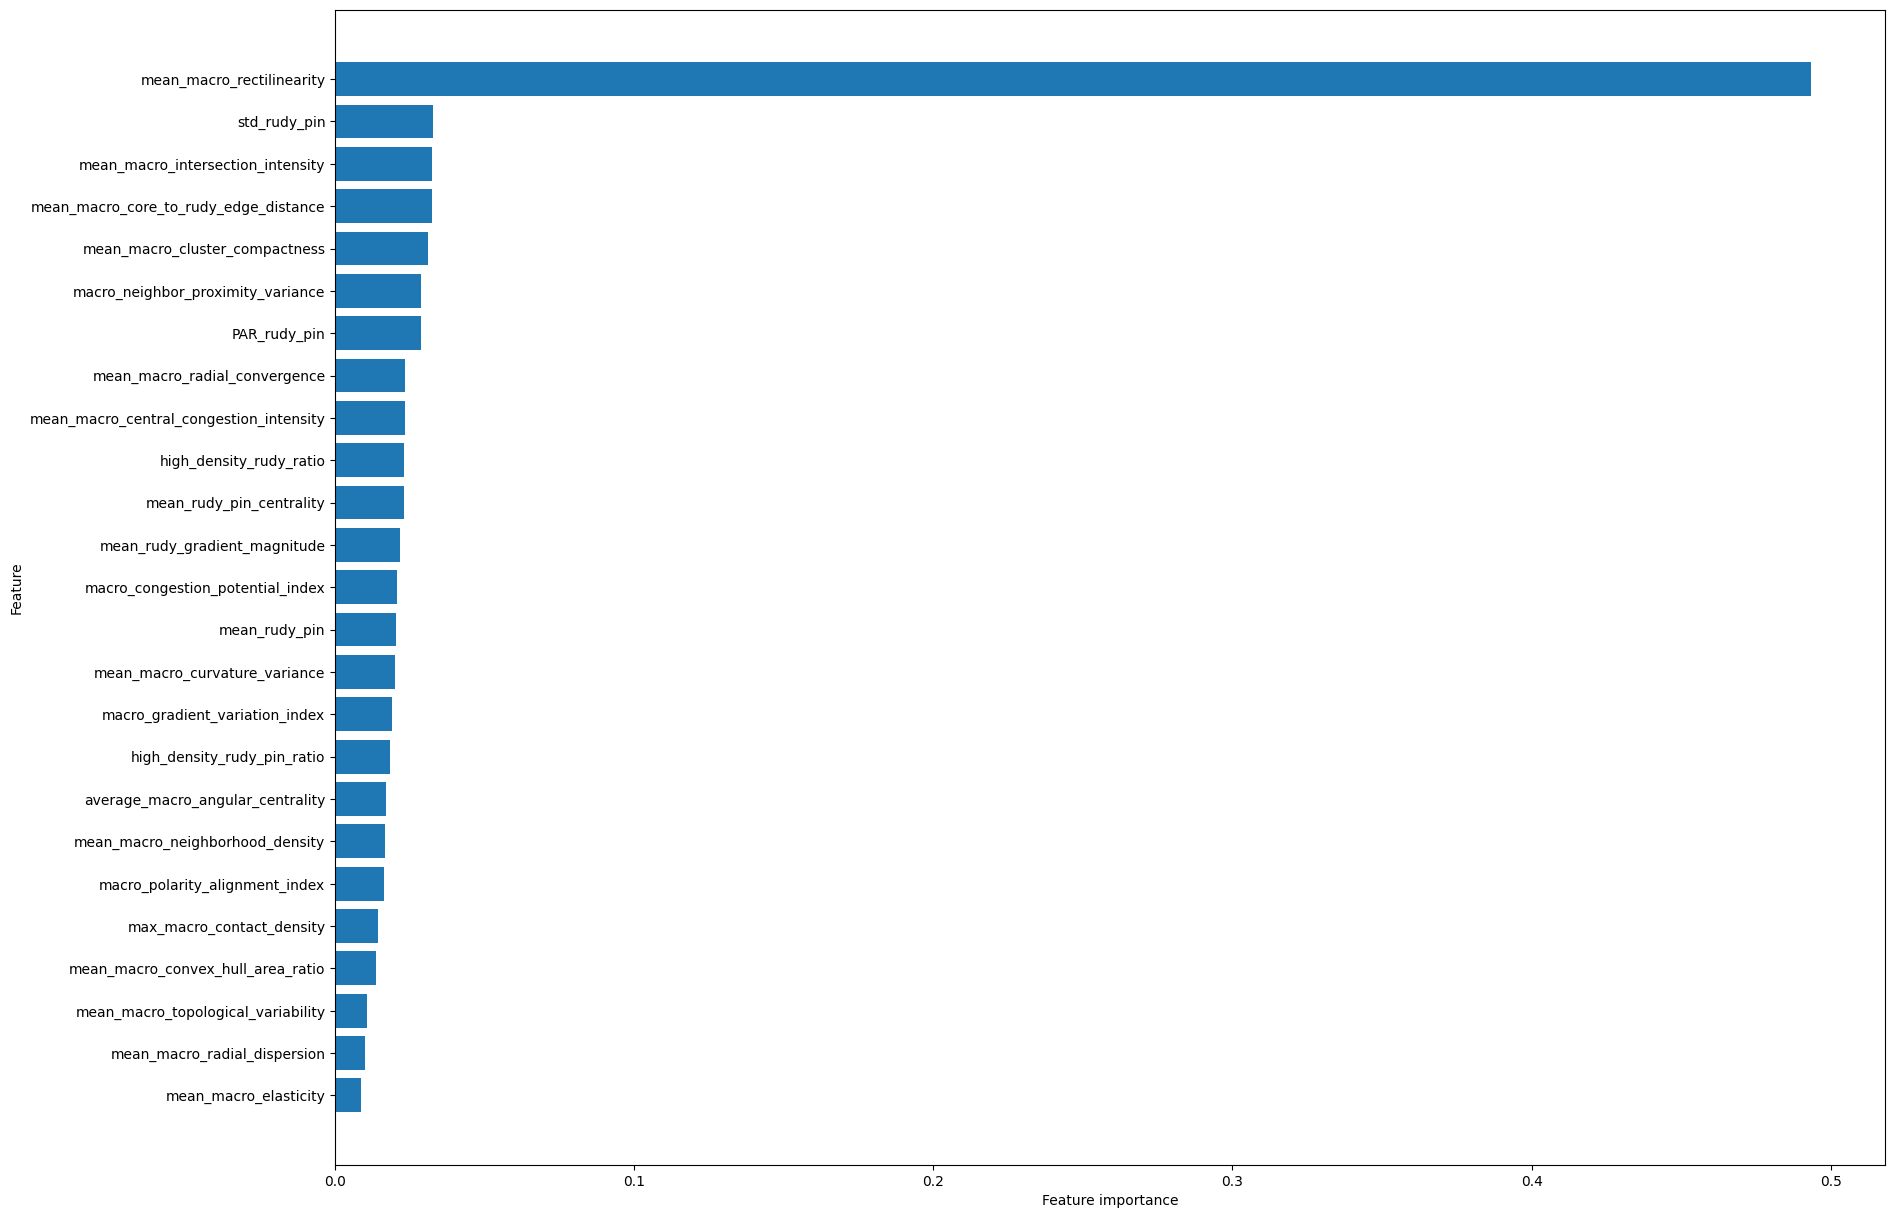

In [244]:
feature_importance = regressor.feature_importances_ 
sorted_idx = np.argsort(feature_importance) # Sort index on feature importance
fig = plt.figure(figsize=(20, 15)) # Set plot size (denoted in inches)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])

plt.xlabel("Feature importance") # Add x axis
plt.ylabel("Feature") # Add y axis

In [ ]:
y_hat_a = regressor.predict(test_df_a.drop(columns=["id", "label", "prediction_gpdl"]))
y_hat_b = regressor.predict(test_df_b.drop(columns=["id", "label", "prediction_gpdl"]))
test_df_a["prediction"] = y_hat_a
test_df_b["prediction"] = y_hat_b

In [252]:
from scipy import stats
from sklearn.metrics import ndcg_score

def evalute_corr(congestion_set, predicted, corr_metrics):
    x = np.array(list(congestion_set.values()))
    predicted = sorted(predicted.items(), key=lambda x: x[1])
    y = np.array([congestion_set[file_path] for file_path, _ in predicted])
    results = {}
    if "PLCC" in corr_metrics:
        results["PLCC"] = stats.pearsonr(x, y)
    if "SRCC" in corr_metrics:
        results["SRCC"] = stats.spearmanr(x, y)
    if "KRCC" in corr_metrics:
        results["KRCC"] = stats.kendalltau(x, y)
    
    return results


def evalute_ndcg(congestion_set, predicted):
    congestion_set = dict(sorted(congestion_set.items(), key=lambda x: x[0]))
    x = np.array(list(congestion_set.values()))
    predicted = dict(sorted(predicted.items(), key=lambda x: x[0]))
    y = np.array(list(predicted.values()))
    return ndcg_score([x], [y])

def evaluate_design(df):
    congestion_set = dict(zip(df["id"], df["label"]))
    congestion_set = dict(sorted(congestion_set.items(), key=lambda x: x[1]))
    predicted = dict(zip(df["id"], df["prediction"]))
    corr_metrics = ["PLCC", "SRCC", "KRCC"]
    results = evalute_corr(congestion_set, predicted, corr_metrics)
    results["NDCG"] = evalute_ndcg(congestion_set, predicted)
    return results

#### Baseline

In [825]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.1440677872814935), pvalue=np.float64(6.136830228930175e-11)),
 'SRCC': SignificanceResult(statistic=np.float64(0.12987480849087346), pvalue=np.float64(3.85691144235756e-09)),
 'KRCC': SignificanceResult(statistic=np.float64(0.08753846973362364), pvalue=np.float64(3.0610691006664493e-09)),
 'NDCG': np.float64(0.9597174164328586)}

In [826]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.16684860167978002), pvalue=np.float64(1.8872803874000822e-08)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1477557449373694), pvalue=np.float64(6.658853690113137e-07)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09888424987077021), pvalue=np.float64(7.070526596401339e-07)),
 'NDCG': np.float64(0.9551973836885712)}

#### Stage 1.

In [25]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.08649899869908996), pvalue=np.float64(9.089138708955547e-05)),
 'SRCC': SignificanceResult(statistic=np.float64(0.10799761174978338), pvalue=np.float64(1.0003287664675104e-06)),
 'KRCC': SignificanceResult(statistic=np.float64(0.07199844897328461), pvalue=np.float64(1.0832094471205787e-06)),
 'NDCG': np.float64(0.9508102811104201)}

In [26]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.08106242004339176), pvalue=np.float64(0.006592959389750979)),
 'SRCC': SignificanceResult(statistic=np.float64(0.11006563989064824), pvalue=np.float64(0.000220834804209146)),
 'KRCC': SignificanceResult(statistic=np.float64(0.07120124060598831), pvalue=np.float64(0.00035560792871340764)),
 'NDCG': np.float64(0.9482617711615231)}

#### Stage 2.

In [63]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.11564093367940911), pvalue=np.float64(1.6055228979854826e-07)),
 'SRCC': SignificanceResult(statistic=np.float64(0.13287981777183258), pvalue=np.float64(1.6629967749484924e-09)),
 'KRCC': SignificanceResult(statistic=np.float64(0.08919891293758796), pvalue=np.float64(1.5341093384595893e-09)),
 'NDCG': np.float64(0.9515041677746379)}

In [64]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.035612177552049346), pvalue=np.float64(0.23329124568561513)),
 'SRCC': SignificanceResult(statistic=np.float64(0.08129257275675326), pvalue=np.float64(0.006440422708954294)),
 'KRCC': SignificanceResult(statistic=np.float64(0.05474571553540896), pvalue=np.float64(0.006038136505592845)),
 'NDCG': np.float64(0.9449789483658896)}

#### Stage 3.

In [105]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.12095495163688913), pvalue=np.float64(4.192028576401967e-08)),
 'SRCC': SignificanceResult(statistic=np.float64(0.13853469806931237), pvalue=np.float64(3.2433471767897927e-10)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09310047457002439), pvalue=np.float64(2.882684533329412e-10)),
 'NDCG': np.float64(0.9516292314469599)}

In [106]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.025394795966915473), pvalue=np.float64(0.3954252844061341)),
 'SRCC': SignificanceResult(statistic=np.float64(0.05640404005820204), pvalue=np.float64(0.058929003858723766)),
 'KRCC': SignificanceResult(statistic=np.float64(0.03659946717563323), pvalue=np.float64(0.06641673424146018)),
 'NDCG': np.float64(0.9455140501723073)}

#### Stage 4.

In [168]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.13439037392460204), pvalue=np.float64(1.081747975689742e-09)),
 'SRCC': SignificanceResult(statistic=np.float64(0.15208215317255971), pvalue=np.float64(4.9023376059519015e-12)),
 'KRCC': SignificanceResult(statistic=np.float64(0.1023879188839902), pvalue=np.float64(4.093211474858967e-12)),
 'NDCG': np.float64(0.952107220372023)}

In [169]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.0725290720285482), pvalue=np.float64(0.015101068972940517)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1016265215173813), pvalue=np.float64(0.0006516694384714082)),
 'KRCC': SignificanceResult(statistic=np.float64(0.06665712354367967), pvalue=np.float64(0.0008284654088731137)),
 'NDCG': np.float64(0.947811390808479)}

#### Stage 5.

In [203]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.14932065885001083), pvalue=np.float64(1.1893810881403534e-11)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1619245172412415), pvalue=np.float64(1.8216421497128883e-13)),
 'KRCC': SignificanceResult(statistic=np.float64(0.10874367315951149), pvalue=np.float64(1.780117622403837e-13)),
 'NDCG': np.float64(0.9531400866227493)}

In [202]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.14354625037584243), pvalue=np.float64(1.379611659818942e-06)),
 'SRCC': SignificanceResult(statistic=np.float64(0.11249079243186486), pvalue=np.float64(0.00015948727005699365)),
 'KRCC': SignificanceResult(statistic=np.float64(0.0759553063740109), pvalue=np.float64(0.00013927976169568316)),
 'NDCG': np.float64(0.9550556467182766)}

#### Stage 6

In [257]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.14011568560765222), pvalue=np.float64(2.0289561027473057e-10)),
 'SRCC': SignificanceResult(statistic=np.float64(0.15754922094050092), pvalue=np.float64(8.07887762476475e-13)),
 'KRCC': SignificanceResult(statistic=np.float64(0.10602409754192019), pvalue=np.float64(6.962231315221366e-13)),
 'NDCG': np.float64(0.9520395947840462)}

In [258]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.025565832683224016), pvalue=np.float64(0.39224934521706356)),
 'SRCC': SignificanceResult(statistic=np.float64(-0.00780318580317616), pvalue=np.float64(0.7940229213419635)),
 'KRCC': SignificanceResult(statistic=np.float64(-0.009601972245417313), pvalue=np.float64(0.6301079178690854)),
 'NDCG': np.float64(0.9470153561799721)}

#### Stage 7

In [294]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.14692485787225854), pvalue=np.float64(2.5323178510357186e-11)),
 'SRCC': SignificanceResult(statistic=np.float64(0.15813685046482126), pvalue=np.float64(6.63005321066558e-13)),
 'KRCC': SignificanceResult(statistic=np.float64(0.10640849494260672), pvalue=np.float64(5.75318966689015e-13)),
 'NDCG': np.float64(0.951744668309129)}

In [295]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.13930796653149805), pvalue=np.float64(2.8139531273158624e-06)),
 'SRCC': SignificanceResult(statistic=np.float64(0.0952377260761834), pvalue=np.float64(0.0014040629686240809)),
 'KRCC': SignificanceResult(statistic=np.float64(0.057909260805598634), pvalue=np.float64(0.0036799668601672103)),
 'NDCG': np.float64(0.9541189964549875)}

#### Stage 8

In [328]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.15282679850358208), pvalue=np.float64(3.849388548213378e-12)),
 'SRCC': SignificanceResult(statistic=np.float64(0.161435549605648), pvalue=np.float64(2.1560165158166503e-13)),
 'KRCC': SignificanceResult(statistic=np.float64(0.1087422334688722), pvalue=np.float64(1.7814190114814724e-13)),
 'NDCG': np.float64(0.9527958437787545)}

In [329]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.15403393141087388), pvalue=np.float64(2.1626676077118466e-07)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1388070368769781), pvalue=np.float64(3.0571191639629897e-06)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09063262952801304), pvalue=np.float64(5.4787653558876505e-06)),
 'NDCG': np.float64(0.9527033743155503)}

#### Stage 9

In [68]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.14814780102662006), pvalue=np.float64(1.7244685342787536e-11)),
 'SRCC': SignificanceResult(statistic=np.float64(0.16334654869115112), pvalue=np.float64(1.112575429160629e-13)),
 'KRCC': SignificanceResult(statistic=np.float64(0.1094563200259528), pvalue=np.float64(1.2383561764486292e-13)),
 'NDCG': np.float64(0.9525303356786453)}

In [69]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.14557168615236682), pvalue=np.float64(9.74201518888154e-07)),
 'SRCC': SignificanceResult(statistic=np.float64(0.12638246056210678), pvalue=np.float64(2.179543044909159e-05)),
 'KRCC': SignificanceResult(statistic=np.float64(0.08108950654101556), pvalue=np.float64(4.763384482252338e-05)),
 'NDCG': np.float64(0.954218859171796)}

#### Stage 10

In [110]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.14743166738521868), pvalue=np.float64(2.1604075438710552e-11)),
 'SRCC': SignificanceResult(statistic=np.float64(0.16252023070970573), pvalue=np.float64(1.482488398829687e-13)),
 'KRCC': SignificanceResult(statistic=np.float64(0.10921493189543431), pvalue=np.float64(1.400684762923566e-13)),
 'NDCG': np.float64(0.952136344320032)}

In [111]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.11430927572242537), pvalue=np.float64(0.00012441966082645577)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1039756028356623), pvalue=np.float64(0.0004859726540404125)),
 'KRCC': SignificanceResult(statistic=np.float64(0.06815380333214044), pvalue=np.float64(0.0006304391846518238)),
 'NDCG': np.float64(0.952805233939173)}

#### Stage 11

In [169]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.1422684254569802), pvalue=np.float64(1.0621294017495063e-10)),
 'SRCC': SignificanceResult(statistic=np.float64(0.15897948642870563), pvalue=np.float64(4.987332693655461e-13)),
 'KRCC': SignificanceResult(statistic=np.float64(0.10669691296734156), pvalue=np.float64(4.983828785677427e-13)),
 'NDCG': np.float64(0.9522810272155507)}

In [170]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.16075785226640166), pvalue=np.float64(6.16201702082964e-08)),
 'SRCC': SignificanceResult(statistic=np.float64(0.13881473193060484), pvalue=np.float64(3.053235935469475e-06)),
 'KRCC': SignificanceResult(statistic=np.float64(0.08817686587935902), pvalue=np.float64(9.76101271477201e-06)),
 'NDCG': np.float64(0.9555399586792915)}

#### Stage 12

In [209]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.1079519672859724), pvalue=np.float64(1.0109538484319745e-06)),
 'SRCC': SignificanceResult(statistic=np.float64(0.13175952524489937), pvalue=np.float64(2.2806505078406586e-09)),
 'KRCC': SignificanceResult(statistic=np.float64(0.08788591507456878), pvalue=np.float64(2.651785485204928e-09)),
 'NDCG': np.float64(0.950695681011622)}

In [210]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.16862797281049757), pvalue=np.float64(1.3246561549877327e-08)),
 'SRCC': SignificanceResult(statistic=np.float64(0.15130138691713022), pvalue=np.float64(3.54826084815364e-07)),
 'KRCC': SignificanceResult(statistic=np.float64(0.10015189470754306), pvalue=np.float64(5.087225362487544e-07)),
 'NDCG': np.float64(0.9543232075731092)}

#### Stage 13

In [247]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.11967448950896241), pvalue=np.float64(5.824657247315559e-08)),
 'SRCC': SignificanceResult(statistic=np.float64(0.14022813779664284), pvalue=np.float64(1.9619811708108864e-10)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09391102039993646), pvalue=np.float64(2.0194849138498369e-10)),
 'NDCG': np.float64(0.95169173860299)}

In [248]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.12672695926232191), pvalue=np.float64(2.068888116033381e-05)),
 'SRCC': SignificanceResult(statistic=np.float64(0.12065246196157428), pvalue=np.float64(5.084424974123191e-05)),
 'KRCC': SignificanceResult(statistic=np.float64(0.07790051294286056), pvalue=np.float64(9.344791271746578e-05)),
 'NDCG': np.float64(0.9499280883163144)}

#### Genetic Algorithm

In [211]:
feat_importances = feature_importance[sorted_idx][-20:]
feat_pool = list(x.columns[sorted_idx])[-20:]

In [212]:
def sigmoid(x, shift=0):
    return 1 / (1 + np.exp(-(x-shift)))

In [213]:
feat_importances = sigmoid((1-feat_importances), shift=1)

In [214]:
feat_importances = {feat: imp for feat, imp in zip(feat_pool, feat_importances)}
feat_pool = {feat: desc[feat] for feat in feat_pool}

In [215]:
import re
import requests
from prompt import CROSS_OVER_PROMPT, MUTATION_PROMPT, DEDUPLICATION_PROMPT, CODE_GEN_PROMPT

def prompt_selection(task_id, desc, feat_pool, feat_importances):
    if task_id == 0:
        prompts = [CROSS_OVER_PROMPT.format(existing_features=desc, feat_pool=feat_pool)]
    else:
        pd = np.random.uniform(0, 1, len(feat_importances))
        prompts = []
        for i, (feat, imp) in enumerate(feat_importances.items()):
            if pd[i] < imp:
                feat = {feat: desc[feat]}
                mutated_prompt = MUTATION_PROMPT.format(existing_features=desc, feature=feat)
                prompts.append(mutated_prompt)
    return prompts

def mllm_single_inference(prompt, type="json"):
    payload = {
    "model": "gpt-4o",
    "messages": [
        {
        "role": "user",
        "content": [
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[0]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[1]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[2]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[3]}"
            }
            },
            {
            "type": "text",
            "text": prompt,
            }
        ]
        }
    ],
    "max_tokens": 2000,
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response = response.json()['choices'][0]['message']['content'] 
    pattern = r"```json([\s\S]*?)```" if type == "json" else r"```python([\s\S]*?)```"
    response = re.search(pattern, response).group(1).strip()
    print(response)
    return response

def feat_extractor(task_id, responses):
    if task_id == 0:
        new_feat = json.loads(responses[0])
    else:
        new_feat = {}
        for response in responses:
            new_feat.update(json.loads(response))
            
    return new_feat

def featgen_inference(prompts):
    responses = []
    for prompt in prompts:
        response = mllm_single_inference(prompt)
        responses.append(response)
    return responses

def deduplicator(feat_pool, new_feat):
    prompt = DEDUPLICATION_PROMPT.format(feat_pool=feat_pool, new_feat_pool=new_feat)
    response = mllm_single_inference(prompt)
    response = json.loads(response)
    dup_feat = [r["feature"] for r in response]
    no_dup_feat = {k: v for k, v in new_feat.items() if k not in dup_feat}
    return no_dup_feat

def code_gen(new_feats):
    responses = []
    for new_feat, definition in new_feats.items():
        prompt = CODE_GEN_PROMPT.format(feature={new_feat: definition}, feature_name=new_feat)
        response = mllm_single_inference(prompt, type="python")
        responses.append(response)
    return responses

In [216]:
task_ids ={0: "cross-over", 1: "mutation"}
task_prob =[0.0, 1] 

def genetic_instruct(feat_pool, feat_importances):
    task_id = np.random.choice(list(task_ids.keys()), p=task_prob)
    print(f"Task: {task_ids[task_id]}")
    prompts = prompt_selection(task_id, desc, feat_pool, feat_importances)
    responses = featgen_inference(prompts)
    new_feats = feat_extractor(task_id, responses)
    no_dup_feat = deduplicator(desc, new_feats)
    return no_dup_feat

In [217]:
new_feat_pool = genetic_instruct(feat_pool, feat_importances)

Task: mutation
{
  "macro_polarity_alignment_index": "a measure of the alignment between the polarity of macro placements and the primary directional flow of routing demand in the layout, calculated by analyzing the orientation angle of macros relative to the main routing demand vectors indicated by RUDY, providing insights into potential routing efficiency or congestion due to macro alignment with or against dominant demand directions"
}
{
  "mean_macro_rudy_gradient_convergence": "the average degree to which the gradient vectors in the RUDY map converge at macro boundaries, indicating potential areas of routing demand intensification near macro edges"
}
{
  "mean_macro_topological_variability": "The average variability in the topological arrangement of macros, calculated by assessing the geometric variation in macro connectivity patterns, indicating potential congestion due to irregular topology and routing complexity."
}
{
  "mean_macro_interstitial_congestion_potential": "the avera

In [218]:
new_feat_pool

{'macro_polarity_alignment_index': 'a measure of the alignment between the polarity of macro placements and the primary directional flow of routing demand in the layout, calculated by analyzing the orientation angle of macros relative to the main routing demand vectors indicated by RUDY, providing insights into potential routing efficiency or congestion due to macro alignment with or against dominant demand directions',
 'mean_macro_topological_variability': 'The average variability in the topological arrangement of macros, calculated by assessing the geometric variation in macro connectivity patterns, indicating potential congestion due to irregular topology and routing complexity.',
 'mean_macro_radial_dispersion': "the average dispersion of macros from central regions outward, indicating potential congestion relief strategies by distributing routing demand across the layout's periphery",
 'mean_macro_convex_hull_area_ratio': 'the average ratio of the convex hull area to the macro ar

In [219]:
error_code = {
  'rudy_geometric_multiplicity': 'a measure of the number of distinct regions in the RUDY map that have the same routing demand value, indicating potential repetitive patterns in routing demand distribution which may affect congestion management',
}
# code_feat = code_gen(error_code)
code_feat = code_gen(new_feat_pool)

import cv2
import numpy as np

def macro_polarity_alignment_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 0-255
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute macro orientations
    macro_orientations = []
    for contour in contours:
        if len(contour) > 5:
            ellipse = cv2.fitEllipse(contour)
            orientation_angle = ellipse[2]  # Angle of the ellipse in degrees
            macro_orientations.append(orientation_angle)

    # Calculate gradient of RUDY to find dominant directions
    gradient_x = cv2.Sobel(rudy_image, cv2.CV_64F, 1, 0, 

#### Stage 1 Function

In [18]:
import numpy as np
import cv2

def max_neighbor_proximity(images):
    tiles_size = 2.25
    macro_image = images[0]

    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours (macros)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate the maximum proximity between neighbor macros
    max_proximity = 0
    for i, cnt1 in enumerate(contours):
        for j, cnt2 in enumerate(contours):
            if i != j:
                # Calculate distance between the bounding rectangles of contours
                rect1 = cv2.boundingRect(cnt1)
                rect2 = cv2.boundingRect(cnt2)

                # Calculate proximity (minimum distance between rectangles)
                dx = max(rect1[0] - (rect2[0] + rect2[2]), rect2[0] - (rect1[0] + rect1[2]), 0)
                dy = max(rect1[1] - (rect2[1] + rect2[3]), rect2[1] - (rect1[1] + rect1[3]), 0)
                distance = np.sqrt(dx**2 + dy**2)

                # Convert distance to micrometers
                distance_um = distance * tiles_size

                # Track the maximum proximity
                max_proximity = max(max_proximity, distance_um)

    feature_value = max_proximity
    return {"max_neighbor_proximity": feature_value}


def mean_macro_rectilinearity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    total_rectilinearity = 0

    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        if area > 0:
            rectilinearity = perimeter / area
            total_rectilinearity += rectilinearity
    
    if num_macros > 0:
        mean_rectilinearity = total_rectilinearity / num_macros
    else:
        mean_rectilinearity = 0

    # Convert from pixel units to micrometers
    mean_rectilinearity = mean_rectilinearity / tiles_size

    return {"mean_macro_rectilinearity": mean_rectilinearity}


def macro_boundary_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert to uint8 and scale the macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the image to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find the contours of the macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize the length of the macro boundary on the edge
    boundary_length_um = 0
    
    # Iterate through contours to check if they touch the boundaries
    for contour in contours:
        for point in contour:
            # Check if the point touches the image boundary
            if point[0][0] == 0 or point[0][0] == macro_image.shape[1] - 1 or \
               point[0][1] == 0 or point[0][1] == macro_image.shape[0] - 1:
                
                # If it touches, calculate the perimeter of the contour
                boundary_length_um += cv2.arcLength(contour, True)
                break
    
    # Convert the perimeter from pixels to micrometers
    boundary_length_um *= tiles_size
    
    # Calculate the density
    image_area_um2 = (macro_image.shape[0] * tiles_size) * (macro_image.shape[1] * tiles_size)
    density = boundary_length_um / image_area_um2
    
    return {"macro_boundary_density": density}

In [19]:
new_feat_func_list = [max_neighbor_proximity, mean_macro_rectilinearity, macro_boundary_density]

In [20]:
new_feat_func_list[2](image_features)

{'macro_boundary_density': 0.0}

In [21]:
feat_func_list = new_feat_func_list

In [22]:
desc.update(new_feat_pool)

NameError: name 'new_feat_pool' is not defined

#### Stage 2 Function

In [23]:
import cv2
import numpy as np

def boundary_pin_concentration(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Convert rudy_pin_image to binary for edge detection
    _, rudy_pin_binary = cv2.threshold(rudy_pin_image, 0.5, 1, cv2.THRESH_BINARY)
    rudy_pin_binary = np.uint8(rudy_pin_binary * 255)
    
    # Detect edges based on the binary pin image
    edges = cv2.Canny(rudy_pin_binary, 100, 200)
    
    # Find contours just along the boundaries
    boundary_contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Count total number of pins (i.e., contours in rudy_pin_image)
    all_contours, _ = cv2.findContours(rudy_pin_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    total_pin_count = len(all_contours)
    
    # Count pins on the boundary
    boundary_pin_count = 0
    for contour in boundary_contours:
        if cv2.contourArea(contour) > 0:
            boundary_pin_count += 1
    
    # Calculate the concentration as the ratio
    boundary_concentration = boundary_pin_count / total_pin_count if total_pin_count > 0 else 0
    
    return {"boundary_pin_concentration": boundary_concentration}


def mean_macro_cluster_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to the range [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate total macro area
    total_macro_area_pixels = sum(cv2.contourArea(contour) for contour in contours)
    total_macro_area_um = total_macro_area_pixels * (tiles_size**2)
    
    # Calculate convex hull area for each cluster
    convex_hull_areas_um = []
    for contour in contours:
        hull = cv2.convexHull(contour)
        hull_area_pixels = cv2.contourArea(hull)
        hull_area_um = hull_area_pixels * (tiles_size**2)
        convex_hull_areas_um.append(hull_area_um)
    
    # Calculate mean macro cluster density
    if convex_hull_areas_um:
        mean_macro_cluster_density = total_macro_area_um / sum(convex_hull_areas_um)
    else:
        mean_macro_cluster_density = 0
    
    return {"mean_macro_cluster_density": mean_macro_cluster_density}


def max_macro_contact_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours in the binary macro image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate area occupied by each macro
    macro_areas = [cv2.contourArea(cnt) for cnt in contours]
    
    # Calculate contact density
    max_density = 0
    for area in macro_areas:
        # Convert pixel area to square micrometers
        area_um2 = area * (tiles_size**2)
        # Compute density as the area occupied by macros in squared micrometers
        density = area_um2 / total_image_area
        # Update maximum density if current density is higher
        if density > max_density:
            max_density = density
    
    # Create the feature dictionary
    feature_name = 'max_macro_contact_density'
    feature_value = max_density
    
    return {feature_name: feature_value}


def mean_rudy_gradient_magnitude(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate gradient magnitude of RUDY map
    grad_x = cv2.Sobel(rudy_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(rudy_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Calculate the mean
    mean_gradient_magnitude = np.mean(gradient_magnitude)
    
    # Convert mean gradient magnitude to the appropriate units (um)
    mean_gradient_magnitude_um = mean_gradient_magnitude * tiles_size
    
    return {"mean_rudy_gradient_magnitude": mean_gradient_magnitude_um}


def macro_intersection_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert the macro image to [0-255] range for binary thresholding
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to find binary image of macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find the contours of the macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    # Initialize the intersection index
    intersection_count = 0
    
    # Calculate intersections between macros and partitions of the layout
    for contour in contours:
        # Get the bounding box of each contour
        x, y, w, h = cv2.boundingRect(contour)
        # Compute the number of intersecting edges with layout tiles
        # Assume each tile is `tiles_size` by `tiles_size`
        
        # Calculate number of vertical and horizontal edges in the bounding box
        num_vertical_edges = int(w / tiles_size)
        num_horizontal_edges = int(h / tiles_size)
        
        # The intersection count is the perimeter of the bounding box divided by the tile size
        intersection_count += 2 * (num_vertical_edges + num_horizontal_edges)
    
    # Calculate the macro intersection index: average number of intersections per macro
    macro_intersection_index = intersection_count / num_macros if num_macros > 0 else 0

    return {"macro_intersection_index": macro_intersection_index}


def mean_macro_aspect_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert to 8-bit image
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize a variable to store the total aspect ratio
    total_aspect_ratio = 0
    
    # Iterate through contours to calculate aspect ratios
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h
        total_aspect_ratio += aspect_ratio
    
    # Calculate mean aspect ratio, handling division by zero
    if len(contours) > 0:
        mean_aspect_ratio = total_aspect_ratio / len(contours)
    else:
        mean_aspect_ratio = 0
    
    return {"mean_macro_aspect_ratio": mean_aspect_ratio}

In [24]:
new_feat_func_list = [boundary_pin_concentration, mean_macro_cluster_density, max_macro_contact_density, mean_rudy_gradient_magnitude, macro_intersection_index, mean_macro_aspect_ratio]

In [25]:
new_feat_func_list[4](image_features)

{'macro_intersection_index': 75.46666666666667}

#### Stage 3 Function

In [35]:
def macro_boundary_asymmetry(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255] and binary
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate edge density for top, bottom, left, and right boundaries
    top_edges = sum([1 for contour in contours for point in contour if point[0][1] == 0])
    bottom_edges = sum([1 for contour in contours for point in contour if point[0][1] == image_height - 1])
    left_edges = sum([1 for contour in contours for point in contour if point[0][0] == 0])
    right_edges = sum([1 for contour in contours for point in contour if point[0][0] == image_width - 1])
    
    # Calculate asymmetry
    vertical_asymmetry = abs(top_edges - bottom_edges) / (top_edges + bottom_edges + 1e-5)
    horizontal_asymmetry = abs(left_edges - right_edges) / (left_edges + right_edges + 1e-5)
    
    # Combine asymmetries
    macro_boundary_asymmetry_value = (vertical_asymmetry + horizontal_asymmetry) / 2
    
    return {"macro_boundary_asymmetry": macro_boundary_asymmetry_value}


def macro_adjacent_connectivity_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours representing macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize adjacency matrix
    adjacency_matrix = np.zeros((len(contours), len(contours)))
    
    # Calculate the adjacency of each pair of macros
    for i, contour1 in enumerate(contours):
        for j, contour2 in enumerate(contours):
            if i != j:
                # Check if they are adjacent by inflating the contour and checking for intersection
                inflated_contour1 = cv2.dilate(binary_image.copy(), np.ones((3, 3), np.uint8))
                intersection = cv2.bitwise_and(inflated_contour1, binary_image)
                if np.any(intersection):
                    adjacency_matrix[i, j] = 1
    
    # Calculate the macro adjacent connectivity index
    num_macros = len(contours)
    if num_macros > 1:
        adjacency_index = np.sum(adjacency_matrix) / (num_macros * (num_macros - 1))
    else:
        adjacency_index = 0
    
    # Convert pixel-based adjacency index to micrometers
    adjacency_index_um = adjacency_index * (tiles_size ** 2)

    return {"macro_adjacent_connectivity_index": adjacency_index_um}


def mean_macro_periphery_proximity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to scale [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    num_macros = len(contours)
    if num_macros == 0:
        return {"mean_macro_periphery_proximity": 0.0}
    
    total_distance = 0

    for contour in contours:
        # Find the centroid of each macro
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0
        
        # Calculate the distance to each boundary and find the minimum
        distances = [
            cX,  # Distance to left
            cY,  # Distance to top
            image_width - cX,  # Distance to right
            image_height - cY  # Distance to bottom
        ]
        min_distance = min(distances)
        
        # Convert distance to micrometers
        distance_um = min_distance * tiles_size
        total_distance += distance_um
    
    # Calculate the mean proximity
    mean_proximity = total_distance / num_macros
    return {"mean_macro_periphery_proximity": mean_proximity}


def mean_macro_diagonal_length(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Binarize the macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the mean diagonal length
    total_diagonal_length = 0.0
    num_macros = len(contours)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        diagonal_length_pixels = np.sqrt(w**2 + h**2)
        diagonal_length_um = diagonal_length_pixels * tiles_size
        total_diagonal_length += diagonal_length_um
    
    # Calculate mean diagonal length
    if num_macros > 0:
        mean_diagonal_length = total_diagonal_length / num_macros
    else:
        mean_diagonal_length = 0.0
    
    return {"mean_macro_diagonal_length": mean_diagonal_length}


def mean_macro_neighborhood_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)

    # Convert macro image to binary
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours which represent macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Set the neighborhood radius in pixels
    neighborhood_radius = 10  # Example size; adjust as needed
    
    # Create a mask for calculating macro density
    macro_mask = np.zeros_like(macro_image)
    
    # Draw the contours onto the mask
    cv2.drawContours(macro_mask, contours, -1, (255), thickness=cv2.FILLED)
    
    # Calculate macro density
    kernel_size = 2 * neighborhood_radius + 1
    macro_area = np.sum(macro_mask > 0)
    total_area = macro_mask.shape[0] * macro_mask.shape[1]
    
    # Calculate neighborhood density using a box filter
    neighborhood_area = cv2.boxFilter(macro_mask, ddepth=cv2.CV_64F, ksize=(kernel_size, kernel_size), normalize=False)
    
    # Convert pixel area to micrometer square
    pixel_area_um2 = tiles_size * tiles_size
    macro_area_um2 = macro_area * pixel_area_um2
    neighborhood_area_um2 = neighborhood_area * pixel_area_um2
    
    # Calculate average macro density within the neighborhood
    mean_density = np.mean(neighborhood_area_um2[macro_mask > 0]) / (kernel_size * kernel_size * pixel_area_um2)
    
    return {"mean_macro_neighborhood_density": mean_density}

In [36]:
new_feat_func_list = [macro_boundary_asymmetry, macro_adjacent_connectivity_index, mean_macro_periphery_proximity, mean_macro_diagonal_length, mean_macro_neighborhood_density]

In [37]:
new_feat_func_list[3](image_features)

{'mean_macro_diagonal_length': np.float64(141.03965457801192)}

#### Stage 4 Function

In [29]:
import cv2
import numpy as np

def mean_macro_diagonal_gradient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to scale [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to binary
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the diagonal gradient of macros
    diagonals = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        diagonal = np.sqrt(w**2 + h**2) * tiles_size
        diagonals.append(diagonal)
    
    # Calculate the gradient of the diagonals
    gradients = []
    for i in range(1, len(diagonals)):
        gradient = np.abs(diagonals[i] - diagonals[i-1])
        gradients.append(gradient)
    
    # Calculate the mean gradient
    if gradients:
        mean_gradient = np.mean(gradients)
    else:
        mean_gradient = 0
        
    return {"mean_macro_diagonal_gradient": mean_gradient}


def macro_coupling_coefficient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to 8-bit grayscale
    macro_image_8bit = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image_8bit, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate the total macro area in um^2
    macro_area_um2 = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        macro_area_um2 += area * (tiles_size**2)
    
    # Calculate the overlap area with RUDY images
    rudy_overlap_area_um2 = 0
    for contour in contours:
        # Create a mask for the current macro
        mask = np.zeros_like(rudy_image)
        cv2.drawContours(mask, [contour], -1, (1,), thickness=cv2.FILLED)
        
        # Calculate overlap with RUDY image
        overlap = np.sum(rudy_image * mask)
        rudy_overlap_area_um2 += overlap * (tiles_size**2)

        # Calculate overlap with RUDY pin image
        overlap_pin = np.sum(rudy_pin_image * mask)
        rudy_overlap_area_um2 += overlap_pin * (tiles_size**2)

    # Compute the macro coupling coefficient
    if macro_area_um2 != 0:
        macro_coupling_coefficient = rudy_overlap_area_um2 / macro_area_um2
    else:
        macro_coupling_coefficient = 0

    return {"macro_coupling_coefficient": macro_coupling_coefficient}


def mean_rudy_pin_centrality(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the centroid of the layout
    centroid_x = image_width / 2
    centroid_y = image_height / 2

    # Find areas of high-density Rudy pin values
    # Assuming high-density is above a certain threshold, e.g., 0.5
    high_density_threshold = 0.5
    high_density_positions = np.argwhere(rudy_pin_image > high_density_threshold)

    # Calculate distances from high-density areas to the centroid
    distances = []
    for pos in high_density_positions:
        y, x = pos
        distance = np.sqrt((x - centroid_x) ** 2 + (y - centroid_y) ** 2)
        distances.append(distance * tiles_size)  # Convert to micrometers

    # Calculate mean centrality
    if len(distances) > 0:
        mean_centrality = np.mean(distances)
    else:
        mean_centrality = 0

    return {"mean_rudy_pin_centrality": mean_centrality}


def macro_center_density_ratio(images):
    tiles_size = 2.25  # um per tile
    macro_image = images[0]
    
    # Image dimensions and area
    image_height, image_width = macro_image.shape
    total_image_area = (image_width * image_height) * (tiles_size ** 2)  # converting to micrometers

    # Convert macro image to binary [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate the area of each macro and the bounding box centers
    macro_area = 0
    center_area = 0

    for contour in contours:
        # Calculate area in micrometers
        area = cv2.contourArea(contour) * (tiles_size ** 2)
        macro_area += area

        # Compute center of the bounding box
        x, y, w, h = cv2.boundingRect(contour)
        center_x, center_y = x + w / 2, y + h / 2

        # Check if the center is in the central quarter
        if (image_width * 0.25 <= center_x <= image_width * 0.75) and (image_height * 0.25 <= center_y <= image_height * 0.75):
            center_area += area

    # Calculate center density ratio
    if macro_area == 0:
        macro_center_density = 0  # To avoid division by zero
    else:
        macro_center_density = center_area / macro_area

    return {"macro_center_density_ratio": macro_center_density}


def mean_macro_cluster_compactness(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Find contours of the macros in the binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    compactness_list = []

    for contour in contours:
        # Calculate the area of the macro
        area = cv2.contourArea(contour)
        if area == 0:
            continue
        
        # Calculate the minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(contour)
        circle_area = np.pi * (radius ** 2)
        
        # Calculate compactness
        compactness = area / circle_area
        compactness_list.append(compactness)
    
    # Calculate the mean compactness
    if compactness_list:
        mean_compactness = np.mean(compactness_list)
    else:
        mean_compactness = 0
    
    # Convert from pixel units to micrometer units
    feature_value = mean_compactness

    return {"mean_macro_cluster_compactness": feature_value}

In [30]:
new_feat_func_list = [mean_macro_diagonal_gradient, macro_coupling_coefficient, mean_rudy_pin_centrality, macro_center_density_ratio, mean_macro_cluster_compactness]

In [31]:
new_feat_func_list[0](image_features)

{'mean_macro_diagonal_gradient': np.float64(62.72571174393669)}

#### Stage 5 Function

In [32]:
def macro_neighbor_proximity_variance(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert the macro image to uint8 and apply binary thresholding
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate centroids of each macro
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            c_x = int(M["m10"] / M["m00"])
            c_y = int(M["m01"] / M["m00"])
            centroids.append((c_x, c_y))
    
    # Calculate pairwise distances between centroids
    distances = []
    for i in range(len(centroids)):
        for j in range(i+1, len(centroids)):
            dist = np.sqrt((centroids[i][0] - centroids[j][0])**2 + (centroids[i][1] - centroids[j][1])**2)
            # Convert distance to micrometers
            dist_um = dist * tiles_size
            distances.append(dist_um)
    
    # Calculate variance of the distances
    if len(distances) > 0:
        variance = np.var(distances)
    else:
        variance = 0.0

    return {"macro_neighbor_proximity_variance": variance}
import cv2
import numpy as np

def mean_macro_perimeter_density(images):
    tiles_size = 2.25  # size in micrometers
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image from [0-1] to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to get binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate total perimeter length in pixels
    total_perimeter_length_pixels = sum(cv2.arcLength(cnt, True) for cnt in contours)
    
    # Convert length from pixels to micrometers
    total_perimeter_length_um = total_perimeter_length_pixels * tiles_size
    
    # Calculate total layout area in micrometers squared
    image_height, image_width = macro_image.shape
    total_image_area_um2 = (image_width * tiles_size) * (image_height * tiles_size)
    
    # Calculate mean macro perimeter density
    mean_macro_perimeter_density = total_perimeter_length_um / total_image_area_um2
    
    return {"mean_macro_perimeter_density": mean_macro_perimeter_density}

# Example usage
# Assuming images is a list of 3 numpy arrays (the images in [0-1])
# result = mean_macro_perimeter_density(images)
# print(result)
import numpy as np
import cv2

def mean_macro_pin_availability(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to get binary macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    macro_areas = [cv2.contourArea(contour) * (tiles_size ** 2) for contour in contours]
    total_macro_area = sum(macro_areas)
    
    # Sum of pin availability from RUDY pin image
    total_pins = np.sum(rudy_pin_image)
    
    # Calculate mean availability of pins per macro area
    if total_macro_area > 0:
        mean_macro_pin_availability = total_pins / total_macro_area
    else:
        mean_macro_pin_availability = 0
    
    return {"mean_macro_pin_availability": mean_macro_pin_availability}

# Example usage
# images = [macro_image_array, rudy_image_array, rudy_pin_image_array]
# feature = mean_macro_pin_availability(images)
# print(feature)
import numpy as np
import cv2

def mean_macro_alignment_deviation(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Apply binary threshold
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # To calculate angular deviation
    deviations = []
    for contour in contours:
        # Get the min area rectangle for each contour
        rect = cv2.minAreaRect(contour)
        angle = rect[-1]
        
        # Convert angles to a deviation from the grid
        if angle < -45:
            angle += 90
        deviation = abs(angle)
        
        deviations.append(deviation)
    
    # Calculate the mean deviation
    if deviations:
        mean_deviation = np.mean(deviations)
    else:
        mean_deviation = 0
    
    return {"mean_macro_alignment_deviation": mean_deviation}

# Example usage:
# mean_macro_alignment_deviation([macro_image, rudy_image, rudy_pin_image])
import numpy as np
import cv2

def macro_central_proximity_flux(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to the range [0-255]
    macro_image = np.uint8(macro_image * 255)

    # Find contours of macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate image center
    image_height, image_width = macro_image.shape
    center_x = image_width / 2
    center_y = image_height / 2

    # Calculate distances from macro centroids to the center
    distances = []
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cX = int(M['m10'] / M['m00'])
            cY = int(M['m01'] / M['m00'])
            distance = np.sqrt((cX - center_x) ** 2 + (cY - center_y) ** 2)
            distances.append(distance * tiles_size)  # Convert distance from pixels to um

    # Calculate average change in distances (this part assumes we're provided with macro placements' history)
    if len(distances) < 2:
        return {"macro_central_proximity_flux": 0}
    
    # Example: Considering some previous distances (which should normally be derived from sequential placements)
    previous_distances = np.roll(distances, 1)  # This is a placeholder example
    flux_values = np.abs(np.array(distances) - np.array(previous_distances))
    average_flux = np.mean(flux_values)
    
    return {"macro_central_proximity_flux": average_flux}
import numpy as np
import cv2

def macro_edge_variability(images):
    tiles_size = 2.25
    macro_image = images[0]    # This is the 'macros' image
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 0-255 scale
    macro_image = np.uint8(macro_image * 255)
    
    # Binarize the macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the edge lengths of all macros
    edge_lengths = []
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        edge_lengths.append(perimeter)
    
    # Convert edge lengths from pixels to micrometers
    edge_lengths_um = [length * tiles_size for length in edge_lengths]
    
    # Calculate the standard deviation of the edge lengths
    if edge_lengths_um:
        std_dev_edge_lengths = np.std(edge_lengths_um)
    else:
        std_dev_edge_lengths = 0

    return {"macro_edge_variability": std_dev_edge_lengths}

In [33]:
new_feat_func_list = [macro_neighbor_proximity_variance, mean_macro_perimeter_density, mean_macro_pin_availability, mean_macro_alignment_deviation, macro_central_proximity_flux, macro_edge_variability]

In [34]:
new_feat_func_list[5](image_features)

{'macro_edge_variability': np.float64(239.33586174267202)}

#### Stage 6 Function

In [38]:
import cv2
import numpy as np

def macro_contour_compaction(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Compute total contour length
    total_contour_length = 0
    for contour in contours:
        contour_length = cv2.arcLength(contour, True)
        total_contour_length += contour_length
        
    # Define idealized contour length (this might be domain-specific; adjust as needed)
    # For demonstration, use the image perimeter as the ideal contour length
    ideal_contour_length = 2 * (image_width + image_height)
    
    # Calculate the macro_contour_compaction feature
    compaction_ratio = total_contour_length / ideal_contour_length
    
    # Convert length to micrometers
    compaction_ratio_um = compaction_ratio * tiles_size
    
    return {"macro_contour_compaction": compaction_ratio_um}

def macro_edge_alignment_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize edge counts
    parallel_edges = 0
    total_edges = 0
    
    for contour in contours:
        for i in range(len(contour)):
            p1 = contour[i][0]
            p2 = contour[(i + 1) % len(contour)][0]
            
            # Calculate differences
            dx = abs(p1[0] - p2[0])
            dy = abs(p1[1] - p2[1])
            
            # Count parallel edges
            if dx == 0 or dy == 0:  # Edge is parallel to one of the principal axes
                parallel_edges += 1
            
            total_edges += 1
    
    # Calculate macro edge alignment index
    if total_edges > 0:
        alignment_index = parallel_edges / total_edges
    else:
        alignment_index = 0
    
    return {"macro_edge_alignment_index": alignment_index}


def mean_macro_periphery_concentration(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Convert the macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Binarize the image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours to detect macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Define boundary distance (e.g., 10% of image width/height as periphery)
    boundary_distance = int(0.1 * min(image_height, image_width))

    # Count macros near the periphery
    boundary_macro_count = 0
    for cnt in contours:
        # Calculate centroid of each contour
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0

        # Check if the centroid is within the boundary distance from the layout edges
        if (cX < boundary_distance or cX > (image_width - boundary_distance) or
            cY < boundary_distance or cY > (image_height - boundary_distance)):
            boundary_macro_count += 1

    # Calculate the mean macro periphery concentration
    mean_concentration = boundary_macro_count / num_macros if num_macros > 0 else 0

    return {"mean_macro_periphery_concentration": mean_concentration}


def average_macro_angular_centrality(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255] range
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold and find contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the layout centroid
    layout_centroid = (image_width / 2, image_height / 2)
    
    # Calculate the centroids of the macros
    macro_centroids = [cv2.moments(contour) for contour in contours]
    macro_centroids = [
        (int(m["m10"] / m["m00"]), int(m["m01"] / m["m00"])) for m in macro_centroids if m["m00"] != 0
    ]
    
    # Calculate angular displacement
    angles = []
    for centroid in macro_centroids:
        dx = centroid[0] - layout_centroid[0]
        dy = centroid[1] - layout_centroid[1]
        angle = np.arctan2(dy, dx)
        angles.append(angle)

    # Calculate the average angular centrality
    average_angular_centrality = np.mean(angles)
    
    return {"average_macro_angular_centrality": np.degrees(average_angular_centrality)}


def macro_gradient_variation_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Scale the macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours to determine the number of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate gradients
    gradient_x = cv2.Sobel(macro_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(macro_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)
    
    # Calculate standard deviation of gradient magnitudes
    macro_gradient_variation_index_value = np.std(gradient_magnitude)
    
    # Convert to appropriate area unit (square micrometers)
    macro_gradient_variation_index_um = macro_gradient_variation_index_value * tiles_size
    
    return {"macro_gradient_variation_index": macro_gradient_variation_index_um}


def mean_macro_intersection_intensity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to 0-255 scale
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to obtain binary image of macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Create a mask from the contours
    macro_mask = np.zeros_like(macro_image)
    cv2.drawContours(macro_mask, contours, -1, 255, thickness=cv2.FILLED)
    
    # Calculate intersections with RUDY and RUDY pin
    intersection_rudy = cv2.bitwise_and(macro_mask, np.uint8(rudy_image * 255))
    intersection_rudy_pin = cv2.bitwise_and(macro_mask, np.uint8(rudy_pin_image * 255))
    
    # Count non-zero pixels for each intersection
    count_intersection_rudy = cv2.countNonZero(intersection_rudy)
    count_intersection_rudy_pin = cv2.countNonZero(intersection_rudy_pin)
    
    # Calculate area in um^2
    area_per_pixel = tiles_size * tiles_size
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    total_area_um2 = total_image_area * area_per_pixel
    
    # Calculate mean intersection intensity per um^2
    mean_intensity = (count_intersection_rudy + count_intersection_rudy_pin) / total_area_um2
    
    return {"mean_macro_intersection_intensity": mean_intensity}

In [39]:
new_feat_func_list = [macro_contour_compaction, macro_edge_alignment_index, mean_macro_periphery_concentration, average_macro_angular_centrality, macro_gradient_variation_index, mean_macro_intersection_intensity]

In [40]:
new_feat_func_list[5](image_features)

{'mean_macro_intersection_intensity': 0.22587227527006173}

#### Stage 7 Function

In [41]:
def mean_macro_peripheral_contact_intensity(images):
    import numpy as np
    import cv2
    
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to 0-255 scale
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the image to get a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours for the macro areas
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the perimeter of macros in contact with the boundary
    image_height, image_width = binary_image.shape
    boundary_length = 2 * (image_height + image_width)
    
    macro_peripheral_contact_length = 0
    
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if x == 0 or y == 0 or x == image_width - 1 or y == image_height - 1:
                macro_peripheral_contact_length += 1

    # Convert the length from pixels to micrometers (um)
    macro_peripheral_contact_length_um = macro_peripheral_contact_length * tiles_size
    
    # Calculate the mean intensity of macro contacts along the periphery
    mean_macro_peripheral_contact_intensity = macro_peripheral_contact_length_um / boundary_length

    return {"mean_macro_peripheral_contact_intensity": mean_macro_peripheral_contact_intensity}



def mean_macro_radial_convergence(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    
    # Convert to binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Compute centroids of macros
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cX = int(M['m10'] / M['m00'])
            cY = int(M['m01'] / M['m00'])
            centroids.append((cX, cY))
    
    # Calculate central point, assuming it is the center of the image
    image_height, image_width = macro_image.shape
    central_point = (image_width // 2, image_height // 2)
    
    # Calculate mean angular difference from the central radial axis (horizontal axis)
    angular_differences = []
    for (cX, cY) in centroids:
        vector = (cX - central_point[0], cY - central_point[1])
        angle = np.arctan2(vector[1], vector[0])  # Angle from horizontal axis
        
        # Calculate angular difference from radial axis (0 or a chosen axis if defined)
        angular_difference = abs(angle)  # Absolute value of angle difference
        angular_differences.append(angular_difference)
    
    mean_angular_difference = np.mean(angular_differences)
    
    # Convert to micrometers
    mean_angular_difference_um = mean_angular_difference * tiles_size
    
    return {"mean_macro_radial_convergence": mean_angular_difference_um}

import cv2
from scipy.stats import entropy

def macro_spatial_entropy(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate macro centers
    macro_centers = [cv2.moments(cnt) for cnt in contours]
    center_positions = [(int(M['m10']/M['m00']), int(M['m01']/M['m00'])) if M['m00'] != 0 else (0, 0) for M in macro_centers]
    
    # Discretize center positions into subregions of the image
    num_subregions = 10
    x_bins = np.linspace(0, image_width, num_subregions + 1)
    y_bins = np.linspace(0, image_height, num_subregions + 1)
    
    # Count macros in each subregion
    histogram, _, _ = np.histogram2d(
        [pos[0] for pos in center_positions],
        [pos[1] for pos in center_positions],
        bins=[x_bins, y_bins]
    )
    
    # Compute entropy
    histogram_flatten = histogram.flatten()
    histogram_flatten_nonzero = histogram_flatten[np.nonzero(histogram_flatten)]
    macro_entropy = entropy(histogram_flatten_nonzero)
    
    return {"macro_spatial_entropy": macro_entropy}



def mean_macro_curvature_variance(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to uint8 and apply binary threshold
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate curvature variance for each macro
    def find_curvature(contour):
        contour = contour.squeeze()
        dx = np.gradient(contour[:, 0])
        dy = np.gradient(contour[:, 1])
        ddx = np.gradient(dx)
        ddy = np.gradient(dy)
        curvature = np.abs(ddx * dy - dx * ddy) / np.power(dx * dx + dy * dy, 3/2 + np.finfo(float).eps)
        return np.var(curvature)
    
    curvature_variances = [find_curvature(contour) for contour in contours]
    
    # Calculate the mean curvature variance
    if num_macros > 0:
        mean_curvature_variance = np.mean(curvature_variances)
    else:
        mean_curvature_variance = 0
    
    feature_value = mean_curvature_variance
    
    return {"mean_macro_curvature_variance": feature_value}


def macro_spatial_variation_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to 0-255 range
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the image to get binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate centroids of macros
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = M['m10'] / M['m00']
            cy = M['m01'] / M['m00']
            centroids.append((cx, cy))
    
    # Calculate distances between centroids
    distances = []
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            distance = np.sqrt((centroids[i][0] - centroids[j][0])**2 + 
                               (centroids[i][1] - centroids[j][1])**2)
            # Convert pixel distance to micrometers
            distance *= tiles_size
            distances.append(distance)
    
    # Calculate standard deviation of distances
    if len(distances) > 0:
        std_dev_distances = np.std(distances)
    else:
        std_dev_distances = 0
    
    return {"macro_spatial_variation_index": std_dev_distances}

In [42]:
new_feat_func_list = [mean_macro_peripheral_contact_intensity, mean_macro_radial_convergence, macro_spatial_entropy, mean_macro_curvature_variance, macro_spatial_variation_index]

In [43]:
new_feat_func_list[0](image_features)

{'mean_macro_peripheral_contact_intensity': 0.0}

#### Stage 8 Function

In [44]:
import numpy as np
import cv2

def macro_radial_proximity_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to uint8 and apply threshold
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Central radial line (vertical center line)
    image_height, image_width = macro_image.shape
    central_x = image_width / 2

    # Calculate the mean distance of each macro's centroid from the central radial line
    total_distance = 0
    num_macros = len(contours)
    
    for contour in contours:
        # Calculate moments to find centroid
        M = cv2.moments(contour)
        if M['m00'] > 0:
            cx = int(M['m10'] / M['m00'])  # x coordinate of centroid
            # Distance of the centroid from the central radial line
            distance = abs(cx - central_x) * tiles_size
            total_distance += distance
    
    # Calculate the mean distance
    if num_macros > 0:
        mean_distance = total_distance / num_macros
    else:
        mean_distance = 0

    # Return the feature as a dictionary
    return {"macro_radial_proximity_index": mean_distance}

def mean_macro_circular_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    total_macro_area = 0
    total_circular_area = 0
    
    for contour in contours:
        # Calculate macro area in pixels
        macro_area = cv2.contourArea(contour)
        total_macro_area += macro_area
        
        # Calculate centroid
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0
        
        # Calculate bounding circle radius based on the largest distance from centroid
        max_distance = max(np.sqrt((cX - x) ** 2 + (cY - y) ** 2) for [[x, y]] in contour)
        
        # Calculate circular area in pixels
        circular_area = np.pi * (max_distance ** 2)
        total_circular_area += circular_area

    # Total macro area and circular area converted to square micrometers
    total_macro_area_um = total_macro_area * (tiles_size ** 2)
    total_circular_area_um = total_circular_area * (tiles_size ** 2)
    
    if total_circular_area_um == 0:
        feature_value = 0
    else:
        # Calculate mean macro circular density
        feature_value = total_macro_area_um / total_circular_area_um

    return {"mean_macro_circular_density": feature_value}


def macro_congestion_potential_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert the macro image to [0, 255] scale
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours in the macro image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate overlap area
    overlap_area = 0.0
    for contour in contours:
        # Create a mask for the current macro
        macro_mask = np.zeros_like(rudy_image)
        cv2.drawContours(macro_mask, [contour], -1, 1, thickness=cv2.FILLED)
        
        # Calculate the intersection density
        overlap = np.sum(rudy_image * macro_mask)
        overlap_area += overlap
    
    # Convert overlap area from pixels to square micrometers
    overlap_area_um2 = overlap_area * (tiles_size ** 2)

    # Normalize by the number of macros and image area
    macro_congestion_potential = overlap_area_um2 / (num_macros * total_image_area * (tiles_size ** 2))
    
    return {"macro_congestion_potential_index": macro_congestion_potential}


def mean_macro_cluster_eccentricity(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert the macro image from [0-1] to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Convert to binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    eccentricities = []
    
    # Calculate eccentricity for each contour
    for contour in contours:
        if len(contour) >= 5:  # Need at least 5 points to fit ellipse
            ellipse = cv2.fitEllipse(contour)
            (center, axes, orientation) = ellipse
            major_axis, minor_axis = max(axes), min(axes)
            
            # Calculate the eccentricity
            if major_axis != 0:
                eccentricity = np.sqrt(1 - (minor_axis / major_axis) ** 2)
                eccentricities.append(eccentricity)
    
    # Calculate the mean eccentricity
    if eccentricities:
        mean_eccentricity = np.mean(eccentricities)
    else:
        mean_eccentricity = 0.0
    
    return {"mean_macro_cluster_eccentricity": mean_eccentricity}


def mean_macro_connectivity_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image from range [0, 1] to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    if num_macros == 0:
        return {"mean_macro_connectivity_density": 0}
    
    # Calculate the total macro area in pixels
    total_macro_area = sum(cv2.contourArea(contour) for contour in contours)
    
    # Convert macro area to µm^2
    total_macro_area_um2 = total_macro_area * (tiles_size ** 2)
    
    # Calculate the total RUDY connectivity paths
    # We assume high intensity in RUDY image indicates high demand for routes
    total_connectivity_demand = np.sum(rudy_image)
    
    # Normalize to ensure the feature result is in terms of total macro area
    mean_connectivity_density = total_connectivity_demand / total_macro_area_um2
    
    return {"mean_macro_connectivity_density": mean_connectivity_density}

In [45]:
new_feat_func_list = [macro_radial_proximity_index, mean_macro_circular_density, macro_congestion_potential_index, mean_macro_cluster_eccentricity, mean_macro_connectivity_density]

In [46]:
new_feat_func_list[2](image_features)

{'macro_congestion_potential_index': np.float64(0.006195560990002695)}

#### Stage 9 Function

In [89]:
import cv2
import numpy as np

def macro_spatial_distribution_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    image_height, image_width = macro_image.shape
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the macro image to get binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    if num_macros == 0:
        return {"macro_spatial_distribution_index": 0.0}

    # Calculate centroids of macros
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))

    centroids = np.array(centroids) * tiles_size # Convert pixel coordinates to um
    
    # Calculate the variance of the centroid positions
    mean_centroid = np.mean(centroids, axis=0)
    variance_centroid = np.mean(np.sum((centroids - mean_centroid) ** 2, axis=1))

    # Normalization (optional - depends on specific requirements)
    feature_value = variance_centroid / (np.sqrt(image_height**2 + image_width**2) * tiles_size)

    return {"macro_spatial_distribution_index": feature_value}

import cv2
import numpy as np
from scipy.stats import entropy

def mean_macro_spatial_entropy(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image array to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Find centroids of macros
    centroids = [cv2.moments(c) for c in contours]
    centroids = [(int(m['m10']/m['m00']), int(m['m01']/m['m00'])) for m in centroids if m['m00'] != 0]
    
    # Create a spatial distribution map
    distribution_map = np.zeros((image_height, image_width))
    for cx, cy in centroids:
        distribution_map[cy, cx] += 1
    
    # Normalize distribution
    distribution_map = distribution_map / distribution_map.sum()
    
    # Calculate entropy
    flat_distribution = distribution_map.flatten()
    flat_distribution = flat_distribution[flat_distribution > 0]  # Remove zero entries
    spatial_entropy = entropy(flat_distribution)

    # Calculate mean macro spatial entropy in um units
    mean_macro_spatial_entropy = spatial_entropy * (tiles_size * tiles_size)
    
    return {"mean_macro_spatial_entropy": mean_macro_spatial_entropy}


def max_macro_corner_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert the macro_image to 0-255 range
    macro_image = np.uint8(macro_image * 255)

    # Binarize the macro_image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours of the macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize a list to hold corner points
    corners = []

    for cnt in contours:
        # Approximate the contour to reduce the number of points
        epsilon = 0.01 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        
        # Collect corner points
        for point in approx:
            corners.append(point[0])  # point[0] is necessary to remove the nested array
    
    # Calculate the corner density in a specified area
    # Assume the specified area is the entire image for now
    # Adapt this part if you want specific tile-based analysis
    
    max_density = 0
    corner_count_grid = np.zeros((256, 256), dtype=np.int32)
    
    # Mark corners in the grid
    for corner in corners:
        x, y = corner
        corner_count_grid[y][x] += 1  # Increment the corner count at this point
    
    max_density = np.max(corner_count_grid)

    # Convert the corner count to density (corners per unit area in um^2)
    area_per_pixel_um2 = tiles_size * tiles_size
    corner_density_um2 = max_density / area_per_pixel_um2  # Corners per um²

    return {"max_macro_corner_density": corner_density_um2}


def mean_macro_central_rudy_pin_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to binary
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    central_rudy_pin_density_sum = 0
    central_area_count = 0
    
    for contour in contours:
        # Find bounding box of each macro
        x, y, w, h = cv2.boundingRect(contour)
        
        # Define central region (e.g., 25% area)
        central_x_start = x + w // 4
        central_y_start = y + h // 4
        central_x_end = x + 3 * w // 4
        central_y_end = y + 3 * h // 4
        
        # Extract central area of RUDY pin image
        central_rudy_pin = rudy_pin_image[central_y_start:central_y_end, central_x_start:central_x_end]
        
        # Calculate density in central area
        central_area = (central_x_end - central_x_start) * (central_y_end - central_y_start)
        central_density = np.sum(central_rudy_pin) / central_area
        
        central_rudy_pin_density_sum += central_density
        central_area_count += 1
    
    # Calculate mean density
    if central_area_count > 0:
        mean_density = central_rudy_pin_density_sum / central_area_count
    else:
        mean_density = 0
    
    return {"mean_macro_central_rudy_pin_density": mean_density}



def mean_macro_cluster_separation(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to binary [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macro clusters
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate centroids of each macro cluster
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cX = int(M['m10'] / M['m00'])
            cY = int(M['m01'] / M['m00'])
            centroids.append((cX, cY))
    
    # Calculate the mean distance between all pairs of centroids
    num_centroids = len(centroids)
    if num_centroids < 2:
        return {"mean_macro_cluster_separation": 0}

    sum_distances = 0
    count_distances = 0
    for i in range(num_centroids):
        for j in range(i + 1, num_centroids):
            dist_x = (centroids[i][0] - centroids[j][0]) * tiles_size
            dist_y = (centroids[i][1] - centroids[j][1]) * tiles_size
            distance = np.sqrt(dist_x**2 + dist_y**2)
            sum_distances += distance
            count_distances += 1

    mean_distance = sum_distances / count_distances
    
    return {"mean_macro_cluster_separation": mean_distance}



def mean_rudy_pin_edge_concentration(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Initialize RUDY pin concentration calculation
    edge_rudy_pin_concentration = 0
    
    # Loop through each macro contour
    for contour in contours:
        # Create a mask for the current macro
        mask = np.zeros_like(rudy_pin_image, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, (1), thickness=cv2.FILLED)
        
        # Find edges of the current macro
        edge_mask = np.zeros_like(mask)
        cv2.drawContours(edge_mask, [contour], -1, (1), thickness=1)
        
        # Calculate the concentration of RUDY pin along the macro edges
        edge_rudy_pins = rudy_pin_image * edge_mask
        edge_rudy_pin_concentration += np.sum(edge_rudy_pins)
    
    # Normalize by total edge length
    total_edge_length = np.sum([cv2.arcLength(contour, True) for contour in contours]) * tiles_size
    if total_edge_length > 0:
        mean_rudy_pin_edge_concentration = edge_rudy_pin_concentration / total_edge_length
    else:
        mean_rudy_pin_edge_concentration = 0
    
    return {"mean_rudy_pin_edge_concentration": mean_rudy_pin_edge_concentration}

In [90]:
new_feat_func_list = [macro_spatial_distribution_index, mean_macro_spatial_entropy, max_macro_corner_density, mean_macro_central_rudy_pin_density, mean_macro_cluster_separation, mean_rudy_pin_edge_concentration]

In [91]:
new_feat_func_list[0](image_features)

{'macro_spatial_distribution_index': np.float64(46.949846290247386)}

#### Stage 10 Function

In [149]:
def rudy_geometric_multiplicity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Convert the RUDY image to integer values for easier processing
    rudy_image_int = np.uint8(rudy_image * 255)

    # Find contours in the RUDY image to detect regions with distinct demands
    rudy_contours, _ = cv2.findContours(rudy_image_int, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate the geometric multiplicity as the number of distinct regions
    geometric_multiplicity = len(rudy_contours)

    return {"rudy_geometric_multiplicity": geometric_multiplicity}


def macro_gradient_alignment_coherence(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to binary
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Compute gradients of the RUDY image
    rudy_dx = cv2.Sobel(rudy_image, cv2.CV_64F, 1, 0, ksize=3)
    rudy_dy = cv2.Sobel(rudy_image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculate gradient magnitudes and angles
    gradient_magnitude = np.sqrt(rudy_dx**2 + rudy_dy**2)
    gradient_angle = np.arctan2(rudy_dy, rudy_dx)
    
    # Edge detection on macro image
    edges = cv2.Canny(binary_image, 100, 200)
    
    # Find gradient angles at macro edges
    edge_indices = np.where(edges != 0)
    edge_gradient_angles = gradient_angle[edge_indices]
    
    # Calculate alignment coherence
    alignment_sum = 0
    count = 0
    
    for cnt in contours:
        for i in range(len(cnt)):
            point = cnt[i][0]
            px, py = point[0], point[1]
            if 0 <= px < image_width and 0 <= py < image_height:
                # Gradient angle at the point
                gradient_angle_at_point = gradient_angle[py, px]
                
                # Check if point is on an edge
                if edges[py, px] != 0:
                    # Compare the macro edge direction with the RUDY gradient at that point
                    edge_angle = np.arctan2(py, px)
                    alignment = np.cos(gradient_angle_at_point - edge_angle)
                    alignment_sum += alignment
                    count += 1
    
    # Calculate average coherence
    if count > 0:
        feature_value = alignment_sum / count
    else:
        feature_value = 0

    return {"macro_gradient_alignment_coherence": feature_value}


def macro_alignment_coherence_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    angles = []
    for contour in contours:
        for i in range(len(contour)):
            p1 = contour[i][0]
            p2 = contour[(i+1) % len(contour)][0]
            delta_x = p2[0] - p1[0]
            delta_y = p2[1] - p1[1]
            angle = np.arctan2(delta_y, delta_x) * (180.0 / np.pi)
            angles.append(angle)
    
    # Normalizing angles to 0-180 degrees
    angles = [abs(angle) % 180 for angle in angles]
    
    # Calculating coherence score
    parallelism_score = sum([1 for angle in angles if angle < 10 or angle > 170])
    perpendicularity_score = sum([1 for angle in angles if 80 < angle < 100])
    
    coherence_index = (parallelism_score + perpendicularity_score) / len(angles) if angles else 0
    
    # Calculate feature value in um and return result
    feature_value = coherence_index * tiles_size
    return {"macro_alignment_coherence_index": feature_value}


def mean_macro_boundary_interaction(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image from [0, 1] to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate boundary interaction
    total_boundary_interaction = 0

    for contour in contours:
        # Calculate perimeter of each macro
        perimeter = cv2.arcLength(contour, True)
        total_boundary_interaction += perimeter
    
    # Convert perimeter from pixel units to micrometers
    total_boundary_interaction_um = total_boundary_interaction * tiles_size
    
    # Calculate mean interaction density
    mean_interaction_density = total_boundary_interaction_um / num_macros if num_macros > 0 else 0
    
    feature_value = mean_interaction_density
    
    return {"mean_macro_boundary_interaction": feature_value}

In [150]:
new_feat_func_list = [rudy_geometric_multiplicity, macro_gradient_alignment_coherence, macro_alignment_coherence_index, mean_macro_boundary_interaction]

In [151]:
new_feat_func_list[0](image_features)

{'rudy_geometric_multiplicity': 1}

#### Stage 11 Function

In [183]:
import cv2
import numpy as np

def mean_macro_symmetry_divergence(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    image_height, image_width = macro_image.shape
    
    # Normalize and threshold macro image
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the center of the image
    image_center = np.array([image_width / 2, image_height / 2])
    
    # Compute the symmetry divergence
    symmetry_divergence = 0
    for contour in contours:
        # Calculate the center of each macro
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            macro_center = np.array([cx, cy])
            
            # Calculate divergence
            divergence = np.linalg.norm(macro_center - image_center)
            symmetry_divergence += divergence
    
    # Calculate mean divergence
    mean_symmetry_divergence = (symmetry_divergence / len(contours)) * tiles_size
    
    return {"mean_macro_symmetry_divergence": mean_symmetry_divergence}

# Example usage:
# images = [macro_image, rudy_image, rudy_pin_image]  # assume these are loaded as numpy arrays
# result = mean_macro_symmetry_divergence(images)
# print(result)
import numpy as np
import cv2

def mean_macro_core_to_rudy_edge_distance(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to 0-255 scale
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Threshold RUDY image to identify high-demand regions
    rudy_threshold = 0.5
    _, rudy_edges = cv2.threshold(np.float32(rudy_image), rudy_threshold, 1, cv2.THRESH_BINARY)
    rudy_edges = np.uint8(rudy_edges * 255)  # Convert for distance transform
    dist_transform = cv2.distanceTransform(cv2.bitwise_not(rudy_edges), cv2.DIST_L2, 3)

    # Calculate distances from macro cores to nearest high-demand edge
    distances = []
    for contour in contours:
        if cv2.contourArea(contour) > 0:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                distances.append(dist_transform[cy, cx])

    # Convert pixel distance to micrometers
    distances_um = [d * tiles_size for d in distances]

    # Calculate mean distance
    mean_distance = np.mean(distances_um) if distances_um else 0

    return {"mean_macro_core_to_rudy_edge_distance": mean_distance}

# Example usage:
# images = [macro_image, rudy_image, rudy_pin_image]
# result = mean_macro_core_to_rudy_edge_distance(images)
# print(result)
import cv2
import numpy as np

def mean_macro_sectorial_distribution_variance(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255] scale for thresholding
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to get binary image of macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Image center
    center = (image_width // 2, image_height // 2)
    
    # Define number of sectors
    num_sectors = 12
    angles = np.linspace(0, 2 * np.pi, num_sectors + 1)
    
    # Initialize sector macro counts
    sector_counts = np.zeros(num_sectors)

    # Calculate macro distribution in sectors
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
        else:
            cx, cy = contour[0][0]

        angle = np.arctan2(cy - center[1], cx - center[0])
        if angle < 0:
            angle += 2 * np.pi
        sector_index = np.searchsorted(angles, angle, side='right') - 1
        sector_counts[sector_index] += 1
    
    # Compute variance of macro counts across sectors
    mean_count = np.mean(sector_counts)
    sectorial_variance = np.var(sector_counts)
    
    # Result in micrometers
    feature_name = 'mean_macro_sectorial_distribution_variance'
    feature_value = sectorial_variance * (tiles_size ** 2)
    
    return {feature_name: feature_value}

# Example images would need to be provided as 3 separate numpy arrays within a list to test this function
import cv2
import numpy as np

def rudy_pin_peripheral_density_contrast(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Define regions
    central_region = (slice(image_height//4, -image_height//4), slice(image_width//4, -image_width//4))
    peripheral_region = (
        (slice(0, image_height//4), slice(None)), 
        (slice(-image_height//4, None), slice(None)),
        (slice(image_height//4, -image_height//4), slice(0, image_width//4)),
        (slice(image_height//4, -image_height//4), slice(-image_width//4, None))
    )
    
    # Calculate densities
    central_density = np.sum(rudy_pin_image[central_region]) / (image_height//2 * image_width//2)
    peripheral_density_sum = 0
    for region in peripheral_region:
        peripheral_density_sum += np.sum(rudy_pin_image[region])
    peripheral_area = (image_height * image_width) - (image_height//2 * image_width//2)
    peripheral_density = peripheral_density_sum / peripheral_area
    
    # Calculate density contrast
    contrast = peripheral_density - central_density
    
    # Convert to um by scaling with tile size
    feature_value = contrast * tiles_size**2
    
    return {"rudy_pin_peripheral_density_contrast": feature_value}
import cv2
import numpy as np

def mean_macro_central_congestion_intensity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert the macro image to 0-255
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macro blocks
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    central_congestion_intensity = []

    for contour in contours:
        # Calculate bounding box of the macro
        x, y, w, h = cv2.boundingRect(contour)

        # Identify central region (e.g., you may define it as the center 50% of each dimension)
        central_x_start = int(x + 0.25 * w)
        central_y_start = int(y + 0.25 * h)
        central_x_end = int(x + 0.75 * w)
        central_y_end = int(y + 0.75 * h)

        # Crop the RUDY map to the central region of the macro
        central_region_rudy = rudy_image[central_y_start:central_y_end, central_x_start:central_x_end]

        # Calculate mean intensity of the central region
        mean_intensity = np.mean(central_region_rudy)
        central_congestion_intensity.append(mean_intensity)

    # Calculate the mean congestion intensity for all central macro regions
    feature_value = np.mean(central_congestion_intensity)

    # Note: Intensity is already normalized [0-1] so no need to multiply with area units
    return {"mean_macro_central_congestion_intensity": feature_value}

In [184]:
new_feat_func_list = [mean_macro_symmetry_divergence, mean_macro_core_to_rudy_edge_distance, mean_macro_sectorial_distribution_variance, rudy_pin_peripheral_density_contrast, mean_macro_central_congestion_intensity]

In [191]:
new_feat_func_list[0](image_features)

IndexError: list index out of range

#### Stage 12 Function

In [221]:
def macro_polarity_alignment_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 0-255
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute macro orientations
    macro_orientations = []
    for contour in contours:
        if len(contour) > 5:
            ellipse = cv2.fitEllipse(contour)
            orientation_angle = ellipse[2]  # Angle of the ellipse in degrees
            macro_orientations.append(orientation_angle)

    # Calculate gradient of RUDY to find dominant directions
    gradient_x = cv2.Sobel(rudy_image, cv2.CV_64F, 1, 0, ksize=5)
    gradient_y = cv2.Sobel(rudy_image, cv2.CV_64F, 0, 1, ksize=5)

    # Compute the magnitude and angle of the gradients
    magnitude, angle = cv2.cartToPolar(gradient_x, gradient_y, angleInDegrees=True)
    
    # Compute average routing direction
    dominant_direction = np.mean(angle[np.where(magnitude > np.mean(magnitude))])

    # Compute alignment index
    alignment_scores = []
    for orientation in macro_orientations:
        difference = min(abs(orientation - dominant_direction), 360 - abs(orientation - dominant_direction))
        alignment_score = (180 - difference) / 180  # Normalize the score to be between 0 and 1
        alignment_scores.append(alignment_score)
    
    # Calculate the final feature value
    if alignment_scores:
        feature_value = np.mean(alignment_scores)
    else:
        feature_value = 0  # If no macros, default alignment is 0

    return {"macro_polarity_alignment_index": feature_value}

# Example usage


def mean_macro_topological_variability(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the area of each macro, convert pixel area to um^2
    macro_areas = [cv2.contourArea(c) * (tiles_size ** 2) for c in contours]
    
    # Calculate the mean variability using the standard deviation of macro areas
    if num_macros > 1:
        feature_value = np.std(macro_areas)
    else:
        feature_value = 0  # If there is only one macro, variability is zero

    return {"mean_macro_topological_variability": feature_value}

# Example usage
# images = [macro_image, rudy_image, rudy_pin_image]
# result = mean_macro_topological_variability(images)
# print(result)
import cv2
import numpy as np

def mean_macro_radial_dispersion(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image_uint8 = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image_uint8, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the center of the image
    center = np.array([image_width / 2.0, image_height / 2.0])
    
    radial_distances = []
    
    for contour in contours:
        # Calculate the moments to get the centroid of the macro
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            centroid = np.array([cx, cy])
            # Calculate the radial distance from the center
            distance = np.linalg.norm(centroid - center)
            radial_distances.append(distance)
    
    if radial_distances:
        # Calculate the mean radial distance in micrometers
        mean_radial_distance_um = np.mean(radial_distances) * tiles_size
    else:
        mean_radial_distance_um = 0
    
    return {"mean_macro_radial_dispersion": mean_radial_distance_um}

# Usage example (assuming images are already loaded as grayscale numpy arrays)
# result = mean_macro_radial_dispersion([macro_image, rudy_image, rudy_pin_image])
# print(result)
import cv2
import numpy as np

def mean_macro_convex_hull_area_ratio(images):
    tiles_size = 2.25  # Each pixel is 2.25um x 2.25um
    macro_image = images[0]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Initialize total ratios
    total_ratio = 0
    
    # Loop through each contour to calculate areas
    for contour in contours:
        # Compute the macro area
        macro_area = cv2.contourArea(contour)
        
        # Compute the convex hull area
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        
        # Calculate the ratio of the convex hull area to the macro area
        if macro_area > 0:
            ratio = hull_area / macro_area
            total_ratio += ratio
    
    # Calculate mean ratio
    mean_ratio = total_ratio / num_macros if num_macros > 0 else 0

    # Convert area units from pixels to um^2
    mean_ratio_um = mean_ratio * (tiles_size ** 2)

    return {"mean_macro_convex_hull_area_ratio": mean_ratio_um}


def mean_macro_elasticity(images):
    tiles_size = 2.25  # size of a pixel in micrometers
    macro_image = images[0]  # Convert to 0-255 scale
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro_image to 0-255 scale for binary thresholding
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the mean elasticity (flexibility of boundaries under routing stress)
    mean_elasticity = 0
    for contour in contours:
        # Calculate the area and perimeter of each macro
        area = cv2.contourArea(contour) * (tiles_size**2)  # Convert area to micrometers squared
        perimeter = cv2.arcLength(contour, True) * tiles_size  # Convert perimeter to micrometers
        
        # Calculate elasticity as a simple radius of curvature approximation or similar
        if perimeter > 0:
            elasticity = area / perimeter
            mean_elasticity += elasticity
            
    if num_macros > 0:
        mean_elasticity /= num_macros
    
    return {"mean_macro_elasticity": mean_elasticity}

In [222]:
new_feat_func_list = [macro_polarity_alignment_index, mean_macro_topological_variability, mean_macro_radial_dispersion, mean_macro_convex_hull_area_ratio, mean_macro_elasticity]

In [229]:
new_feat_func_list[0](image_features)

{'macro_polarity_alignment_index': np.float64(0.4569053183977262)}

#### Stage 13 Function

In [37]:
import numpy as np
import cv2

def demarcated_macro_proximity_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    
    image_height, image_width = macro_image.shape
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the macro image to find contours of the macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Threshold for defining high-density areas in RUDY map
    rudy_threshold = 0.5
    
    # Identifying high-density zones in RUDY
    high_density_zone = rudy_image > rudy_threshold
    
    # Initialize a variable to accumulate proximity measure
    proximity_sum = 0
    
    # Calculate proximity index
    for contour in contours:
        macro_mask = np.zeros_like(macro_image)
        cv2.drawContours(macro_mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        intersection = np.logical_and(macro_mask > 0, high_density_zone)
        intersection_area = np.sum(intersection) * tiles_size * tiles_size
        
        # Proximity for current macro
        proximity_sum += intersection_area
        
    # Normalizing by total macro area
    total_macro_area = np.sum(macro_image > 0) * tiles_size * tiles_size
    demarcated_macro_proximity_index = (proximity_sum / (total_macro_area + 1e-5)) if total_macro_area > 0 else 0
    
    return {"demarcated_macro_proximity_index": demarcated_macro_proximity_index}


def macro_surface_irregularity_index(images):
    import cv2
    import numpy as np
    
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)  # Convert area to micrometers

    macro_image = np.uint8(macro_image * 255)  # Convert macro image to [0-255]
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate total perimeter and area of macros
    total_perimeter = 0
    total_macro_area = 0
    for contour in contours:
        total_perimeter += cv2.arcLength(contour, True)
        total_macro_area += cv2.contourArea(contour)

    # Convert perimeter and area to micrometers
    total_perimeter_um = total_perimeter * tiles_size
    total_macro_area_um = total_macro_area * (tiles_size ** 2)

    # Irregularity index calculation
    if total_macro_area_um > 0:
        irregularity_index = total_perimeter_um / total_macro_area_um
    else:
        irregularity_index = 0

    return {"macro_surface_irregularity_index": irregularity_index}


def macro_rudy_boundary_interaction_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate interaction index
    interaction_index = 0
    
    # Iterate over each contour
    for contour in contours:
        # Create a mask of the macro contour
        contour_mask = np.zeros((image_height, image_width), dtype=np.uint8)
        cv2.drawContours(contour_mask, [contour], -1, (1), thickness=cv2.FILLED)
        
        # Calculate the intersection of the macro contour with RUDY pin image
        interaction_area = np.sum(contour_mask * rudy_pin_image)
        
        # Convert pixels to area in um^2 (each pixel is 2.25um x 2.25um)
        interaction_area_um = interaction_area * (tiles_size ** 2)
        
        # Check if the averaged RUDY pin density along macro boundary indicates congestion
        if interaction_area > 0:
            interaction_index += interaction_area_um / cv2.arcLength(contour, True) * tiles_size

    return {"macro_rudy_boundary_interaction_index": interaction_index}

def pin_density_peak_contrast(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Compute pin density peaks
    # Using a kernel to emphasize local density peaks
    kernel_size = 3  # Define an appropriate kernel size
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size**2)
    smoothed_rudy_pin = cv2.filter2D(rudy_pin_image, -1, kernel)
    
    # Find pin density peak contrast
    pin_density_peak = np.max(smoothed_rudy_pin)
    avg_density_around_peaks = np.mean(smoothed_rudy_pin)
    
    # Compute the contrast
    contrast = pin_density_peak - avg_density_around_peaks

    # Convert image dimensions to a physical measurement
    contrast_um = contrast * tiles_size  # Convert to um using the tile size
    
    return {"pin_density_peak_contrast": contrast_um}


def rudy_pin_density_flux_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Process the RUDY pin image
    # Compute the gradients along the x and y axis
    grad_x = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute the gradient magnitude
    grad_magnitude = cv2.magnitude(grad_x, grad_y)
    
    # Calculate the mean of the gradient magnitude to represent density flux
    mean_flux = np.mean(grad_magnitude)
    
    # Normalize to area in square micrometers (um^2)
    pixel_area = tiles_size ** 2
    total_area_um2 = total_image_area * pixel_area
    
    feature_value = mean_flux / total_area_um2
    
    return {"rudy_pin_density_flux_index": feature_value}

In [925]:
new_feat_func_list = [demarcated_macro_proximity_index, macro_surface_irregularity_index, macro_rudy_boundary_interaction_index, pin_density_peak_contrast, rudy_pin_density_flux_index]

#### Updating pool

In [230]:
feat_func_list = [feat_func for feat_func in feat_func_list if feat_func.__name__ in list(feat_pool)]

In [231]:
feat_func_list = feat_func_list + new_feat_func_list

In [232]:
feat_func_list

[<function __main__.mean_macro_rectilinearity(images)>,
 <function __main__.max_macro_contact_density(images)>,
 <function __main__.mean_rudy_gradient_magnitude(images)>,
 <function __main__.mean_macro_neighborhood_density(images)>,
 <function __main__.mean_rudy_pin_centrality(images)>,
 <function __main__.mean_macro_cluster_compactness(images)>,
 <function __main__.macro_neighbor_proximity_variance(images)>,
 <function __main__.average_macro_angular_centrality(images)>,
 <function __main__.macro_gradient_variation_index(images)>,
 <function __main__.mean_macro_intersection_intensity(images)>,
 <function __main__.mean_macro_radial_convergence(images)>,
 <function __main__.mean_macro_curvature_variance(images)>,
 <function __main__.macro_congestion_potential_index(images)>,
 <function __main__.mean_macro_core_to_rudy_edge_distance(images)>,
 <function __main__.mean_macro_central_congestion_intensity(images)>,
 <function __main__.macro_polarity_alignment_index(images)>,
 <function __main

In [233]:
desc.update(new_feat_pool)

#### Final Selection

In [253]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.15303314478597885), pvalue=np.float64(3.599156588509613e-12)),
 'SRCC': SignificanceResult(statistic=np.float64(0.16029674617139997), pvalue=np.float64(3.1859200603957296e-13)),
 'KRCC': SignificanceResult(statistic=np.float64(0.10835015771810952), pvalue=np.float64(2.1729465569835168e-13)),
 'NDCG': np.float64(0.9557754713900827)}

In [254]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.1723293942850892), pvalue=np.float64(6.26702076345169e-09)),
 'SRCC': SignificanceResult(statistic=np.float64(0.16678647912598293), pvalue=np.float64(1.910619196943313e-08)),
 'KRCC': SignificanceResult(statistic=np.float64(0.1141437035269792), pvalue=np.float64(1.0359513670882002e-08)),
 'NDCG': np.float64(0.9513183012649215)}

In [255]:
feat_pool

{'average_macro_angular_centrality': 'the average angular alignment of macros relative to the layout center, indicating placement symmetry and routing balance',
 'high_density_rudy_pin_ratio': 'the ratio of hotspots area in the rudy pin map',
 'mean_macro_neighborhood_density': 'the average density of macros within defined neighborhood regions, indicating local macro clustering',
 'macro_congestion_potential_index': 'a measure of potential congestion around macros, calculated by evaluating the intersection density of rudy map hotspots with macro areas, indicating areas where macros might contribute to routing congestion due to overlapping high-demand regions',
 'mean_rudy_gradient_magnitude': 'the average magnitude of the gradient in the RUDY map, indicating the overall intensity of routing demand shifts across the layout',
 'max_macro_contact_density': 'the maximum density of direct contact between macro edges, indicating areas with high macro interaction and potential congestion',
 '

In [256]:
feat_func_list

[<function __main__.mean_macro_rectilinearity(images)>,
 <function __main__.max_macro_contact_density(images)>,
 <function __main__.mean_rudy_gradient_magnitude(images)>,
 <function __main__.mean_macro_neighborhood_density(images)>,
 <function __main__.mean_rudy_pin_centrality(images)>,
 <function __main__.mean_macro_cluster_compactness(images)>,
 <function __main__.macro_neighbor_proximity_variance(images)>,
 <function __main__.average_macro_angular_centrality(images)>,
 <function __main__.macro_gradient_variation_index(images)>,
 <function __main__.mean_macro_intersection_intensity(images)>,
 <function __main__.mean_macro_radial_convergence(images)>,
 <function __main__.mean_macro_curvature_variance(images)>,
 <function __main__.macro_congestion_potential_index(images)>,
 <function __main__.mean_macro_core_to_rudy_edge_distance(images)>,
 <function __main__.mean_macro_central_congestion_intensity(images)>,
 <function __main__.macro_polarity_alignment_index(images)>,
 <function __main

In [69]:
train_df = train_df[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"]]
test_df_a = test_df_a[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"]]
test_df_b = test_df_b[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"]]

#### CheckPoint

In [234]:
feat_func_list

[<function __main__.mean_macro_rectilinearity(images)>,
 <function __main__.max_macro_contact_density(images)>,
 <function __main__.mean_rudy_gradient_magnitude(images)>,
 <function __main__.mean_macro_neighborhood_density(images)>,
 <function __main__.mean_rudy_pin_centrality(images)>,
 <function __main__.mean_macro_cluster_compactness(images)>,
 <function __main__.macro_neighbor_proximity_variance(images)>,
 <function __main__.average_macro_angular_centrality(images)>,
 <function __main__.macro_gradient_variation_index(images)>,
 <function __main__.mean_macro_intersection_intensity(images)>,
 <function __main__.mean_macro_radial_convergence(images)>,
 <function __main__.mean_macro_curvature_variance(images)>,
 <function __main__.macro_congestion_potential_index(images)>,
 <function __main__.mean_macro_core_to_rudy_edge_distance(images)>,
 <function __main__.mean_macro_central_congestion_intensity(images)>,
 <function __main__.macro_polarity_alignment_index(images)>,
 <function __main

In [235]:
new_feat_pool

{'macro_polarity_alignment_index': 'a measure of the alignment between the polarity of macro placements and the primary directional flow of routing demand in the layout, calculated by analyzing the orientation angle of macros relative to the main routing demand vectors indicated by RUDY, providing insights into potential routing efficiency or congestion due to macro alignment with or against dominant demand directions',
 'mean_macro_topological_variability': 'The average variability in the topological arrangement of macros, calculated by assessing the geometric variation in macro connectivity patterns, indicating potential congestion due to irregular topology and routing complexity.',
 'mean_macro_radial_dispersion': "the average dispersion of macros from central regions outward, indicating potential congestion relief strategies by distributing routing demand across the layout's periphery",
 'mean_macro_convex_hull_area_ratio': 'the average ratio of the convex hull area to the macro ar

In [236]:
desc

{'macro_area_ratio': 'the ratio of total macros area in the layout',
 'mean_macro_edge_length': 'the edge length of all macros calculated by average',
 'mean_macro_neighbor_distance': 'the total near distances of macros calculated by average',
 'min_rudy': 'the minimum value of the rudy map',
 'max_rudy': 'the maximum value of the rudy map',
 'mean_rudy': 'the average of the rudy map',
 'std_rudy': 'the standard deviation of the rudy map',
 'PAR_rudy': 'the Peak-to-Average Ratio of the rudy map',
 'high_density_rudy_ratio': 'the ratio of hotspots area in the rudy map',
 'min_rudy_pin': 'the minimum value of the rudy pin map',
 'max_rudy_pin': 'the maximum value of the rudy pin map',
 'mean_rudy_pin': 'the average of the rudy pin map',
 'std_rudy_pin': 'the standard deviation of the rudy pin map',
 'PAR_rudy_pin': 'the Peak-to-Average Ratio of the rudy pin map',
 'high_density_rudy_pin_ratio': 'the ratio of hotspots area in the rudy pin map',
 'mean_macro_rectilinearity': 'the average r

In [237]:
feat_pool

{'average_macro_angular_centrality': 'the average angular alignment of macros relative to the layout center, indicating placement symmetry and routing balance',
 'high_density_rudy_pin_ratio': 'the ratio of hotspots area in the rudy pin map',
 'mean_macro_neighborhood_density': 'the average density of macros within defined neighborhood regions, indicating local macro clustering',
 'macro_congestion_potential_index': 'a measure of potential congestion around macros, calculated by evaluating the intersection density of rudy map hotspots with macro areas, indicating areas where macros might contribute to routing congestion due to overlapping high-demand regions',
 'mean_rudy_gradient_magnitude': 'the average magnitude of the gradient in the RUDY map, indicating the overall intensity of routing demand shifts across the layout',
 'max_macro_contact_density': 'the maximum density of direct contact between macro edges, indicating areas with high macro interaction and potential congestion',
 '